In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modules.histomics import reg_edge, vesselness
import tables
from IPython.display import display, Javascript
from modules import utility
from sklearn.metrics import f1_score
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

def DRLS(img,rad=30, scale=255, sigma=0.5, alpha=0.4, lamda=1.0, iter=200,mu=0.2):
    imgt = np.zeros_like(img).astype(float)
    h,w = imgt.shape
    for i in range(imgt.shape[0]):
        for j in range(imgt.shape[1]):
            if np.sqrt((i-h/2)**2+(j-w/2)**2) <= rad:
                imgt[i,j]=-1.0
         
    ls = reg_edge(img*scale,imgt,sigma=sigma,alpha=alpha,
                  lamda=lamda,iter=iter,mu=mu)
    
    conts = utility.marchingSquares(-ls.astype(np.float32),iso=0.0,mode='center')
    
    ls = utility.threshold(-ls,0.0)
    
    return ls,conts

def get_params():
    rad_range = [10,70]
    sca_range = [100,500]
    sig_range = [0.1,2.0]
    alp_range = [-1,3]
    lam_range = [0.1,3.0]
    ite_range = [30,200]
    mu_range  = [0.1,1.0]
    r     = np.random.randint(low=rad_range[0], high=rad_range[1])
    scale = np.random.rand()*(sca_range[1]-sca_range[0])+sca_range[0]
    sig   = np.random.rand()*(sig_range[1]-sig_range[0])+sig_range[0]
    alpha = np.random.rand()*(alp_range[1]-alp_range[0])+alp_range[0]
    lamda = np.random.rand()*(lam_range[1]-lam_range[0])+lam_range[0]
    iter_ = np.random.randint(low=ite_range[0],high=ite_range[1])
    mu    = np.random.rand()*(mu_range[1]-mu_range[0])+mu_range[0]
    
    d = {'r':r, 'scale':scale, 'sig':sig, 'alpha':alpha, 'lambda':lamda, 'iter':iter_, 'mu':mu}
    
    return d

def eval_drls(X,Y):
    N,H,W = X.shape
    segs = np.zeros((N,H,W))
    conts = []
    params = get_params()
    R     = params['r']
    alpha = params['alpha']
    lamda = params['alpha']
    scale = params['scale']
    mu    = params['mu']
    iter_ = params['iter']
    
    for i in range(N):

        img = X[i,:,:]
        seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,scale=scale)
        segs[i] = seg
        
    F = f1_score(np.ravel(Y).astype(int), np.ravel(segs).astype(int))
    return F,params

Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
#######################################################
# Get data
#######################################################
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'

#ct data
CODE ='ct'
train = data_path+'train_192_ct.hdf5'
val = data_path+'val_192_ct.hdf5'
test = data_path+'test_192_ct.hdf5'

#mr data
# CODE ='mr'
# train = data_path+'train_192_mr.hdf5'
# val = data_path+'val_192_mr.hdf5'
# test = data_path+'test_192_mr.hdf5'


f_train = tables.open_file(train)
f_val = tables.open_file(val)


input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)
print f_val.root.X.shape
print f_val.root.X.dtype
N = f_train.root.X.shape[0]

CROP_DIMS = 90

(80004, 192, 192, 1) (80004, 192, 192, 1)
data shapes, train=(80004, 192, 192, 1),(80004, 192, 192, 1)
(4333, 192, 192, 1)
float32


In [3]:
x = np.asarray(f_val.root.X[::12,:,:,0]).astype(float)
x = utility.crop_center_nd(x,CROP_DIMS,CROP_DIMS)
y = np.asarray(f_val.root.Y[::12,:,:,0]).astype(int)
y = utility.crop_center_nd(y,CROP_DIMS,CROP_DIMS)
print x.shape,y.shape

(362, 90, 90) (362, 90, 90)


In [4]:
%timeit DRLS(x[0])

1 loop, best of 3: 276 ms per loop


In [7]:
RES = [eval_drls(x,y) for i in range(50)]


modules/histomics.py:276: RuntimeWarning:

overflow encountered in square

modules/histomics.py:276: RuntimeWarning:

overflow encountered in add

modules/histomics.py:318: RuntimeWarning:

invalid value encountered in sin

modules/histomics.py:316: RuntimeWarning:

invalid value encountered in less_equal

modules/histomics.py:316: RuntimeWarning:

invalid value encountered in greater_equal

modules/histomics.py:317: RuntimeWarning:

invalid value encountered in greater

modules/histomics.py:333: RuntimeWarning:

invalid value encountered in greater

modules/utility.py:1342: RuntimeWarning:

invalid value encountered in less

modules/utility.py:1344: RuntimeWarning:

invalid value encountered in less

modules/utility.py:1345: RuntimeWarning:

invalid value encountered in greater_equal

/home/marsdenlab/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



In [8]:
RES = sorted(RES,key = lambda x: -x[0])
print RES

[(0.11478632934339261, {'scale': 305.5581607005278, 'iter': 45, 'mu': 0.19994411447947996, 'r': 30, 'sig': 1.4276062749991574, 'alpha': 2.513490679362109, 'lambda': 2.4560100446978135}), (0.088638159385135612, {'scale': 238.23373425439894, 'iter': 33, 'mu': 0.24615807060374623, 'r': 42, 'sig': 1.1518889058651225, 'alpha': 1.6284762376416562, 'lambda': 0.920868729474562}), (0.085241067229347545, {'scale': 370.5441621275279, 'iter': 67, 'mu': 0.1784765477849872, 'r': 35, 'sig': 1.5893667455331084, 'alpha': 2.831200424610711, 'lambda': 2.2023008395603223}), (0.083082835591066231, {'scale': 493.8811507752346, 'iter': 123, 'mu': 0.20415354452242662, 'r': 42, 'sig': 1.536326075299091, 'alpha': 1.3221357150856363, 'lambda': 1.9164648004221891}), (0.054383423826716591, {'scale': 462.0153470062745, 'iter': 61, 'mu': 0.13099569704462635, 'r': 32, 'sig': 1.9650501271880685, 'alpha': -0.8663486869108215, 'lambda': 1.6647301122332163}), (0.04522995033636671, {'scale': 457.9032159484271, 'iter': 76,

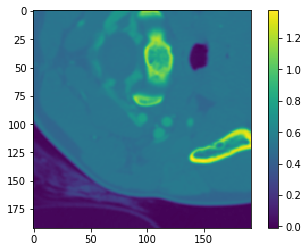

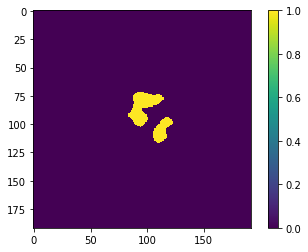

In [3]:
img = f_val.root.X[2500,:,:,0].astype(float)
plt.imshow(img.astype(np.float32))
plt.colorbar()
plt.show()

plt.figure()
seg,conts = DRLS(img)
plt.imshow(seg.astype(np.float32))
plt.colorbar()
plt.show()

In [4]:
#[(0.11478632934339261, {'scale': 305.5581607005278, 'iter': 45, 'mu': 0.19994411447947996, 
#'r': 30, 'sig': 1.4276062749991574, 'alpha': 2.513490679362109, 'lambda': 2.4560100446978135})
scale = 305.6
iter_ = 100
alpha = 0.9
R = 30
mu = 0.2
sig = 0.5
lamda = 2.0

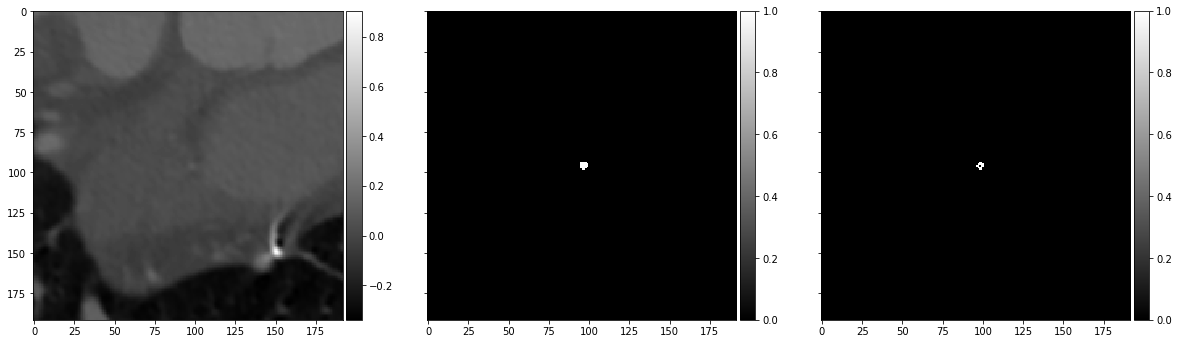

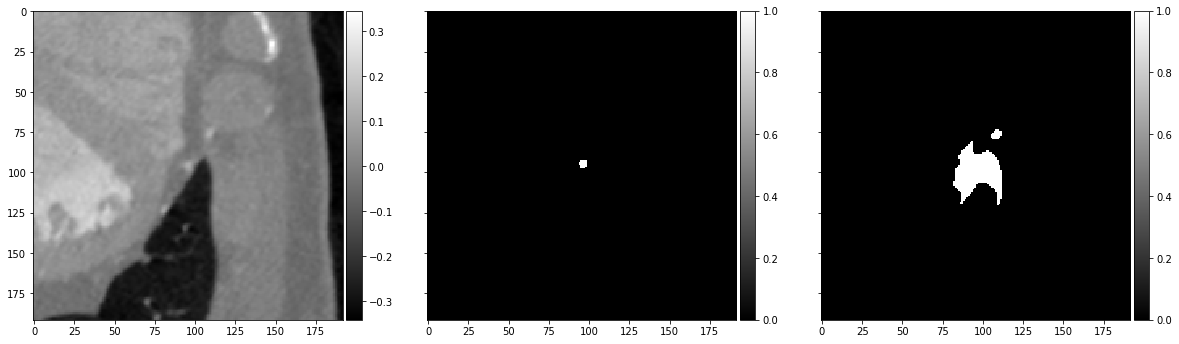

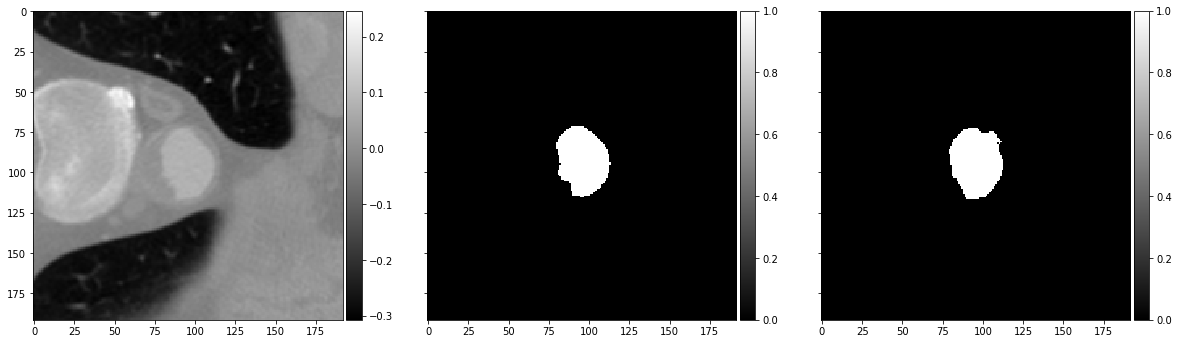

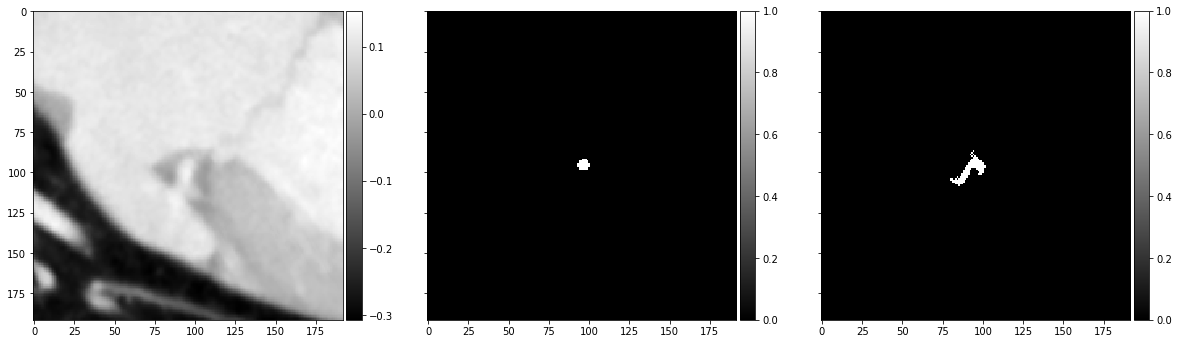

In [5]:
######################################################
# Plot
######################################################

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(4):
    j = np.random.randint(N)
    im = f_train.root.X[j,:,:,0].astype(float)
    truth = f_train.root.Y[j,:,:,0].astype(float)
    seg,conts = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    implot(im,ax1)
    implot(truth,ax2)
    implot(seg,ax3)
    plt.tight_layout
    plt.show()

In [6]:
f_test = tables.open_file(test)
X = f_test.root.X
Y = f_test.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

(20463, 192, 192, 1)
(20463, 192, 192, 1)


In [7]:
segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0]
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [8]:
np.save('drls_segs_{}.npy'.format(CODE),segs)
np.save('drls_conts_{}.npy'.format(CODE),conts)

In [9]:
segs = np.load('drls_segs_{}.npy'.format(CODE))
conts = np.load('drls_conts_{}.npy'.format(CODE))

In [6]:
#mr data
CODE ='mr'
train = data_path+'train_192_mr.hdf5'
val = data_path+'val_192_mr.hdf5'
test = data_path+'test_192_mr.hdf5'

f_train = tables.open_file(train)
f_val = tables.open_file(val)
f_test = tables.open_file(test)

X = f_test.root.X
Y = f_test.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

(10414, 192, 192, 1)
(10414, 192, 192, 1)


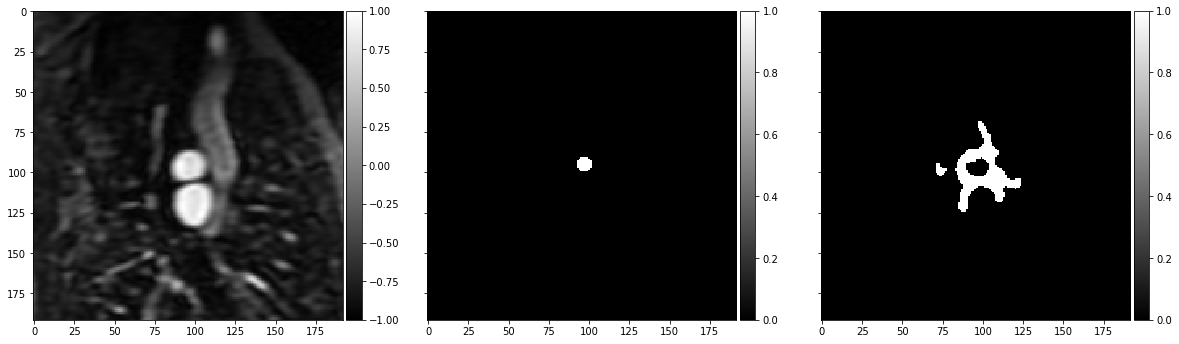

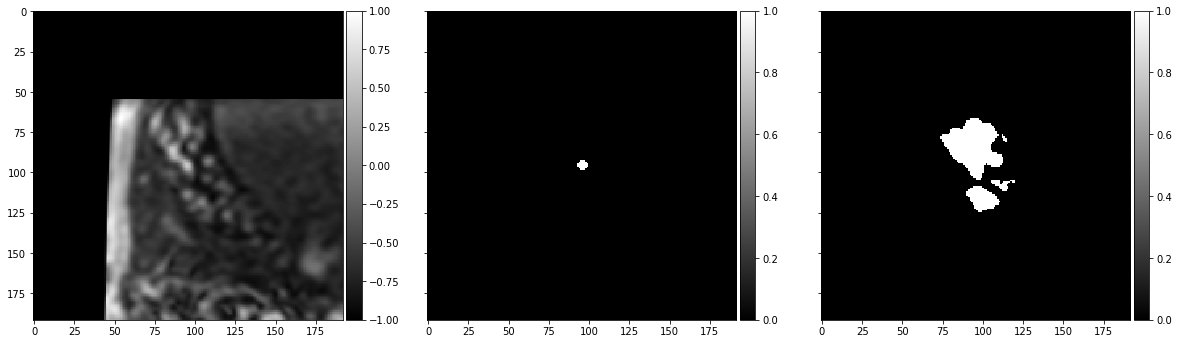

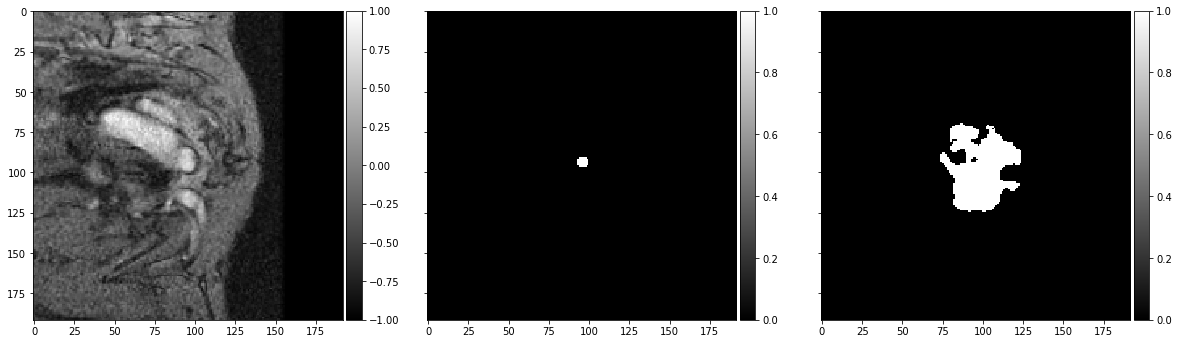

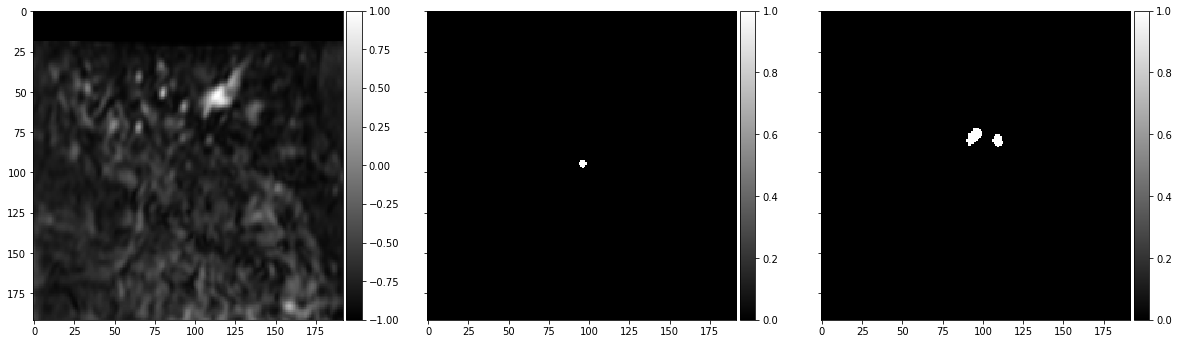

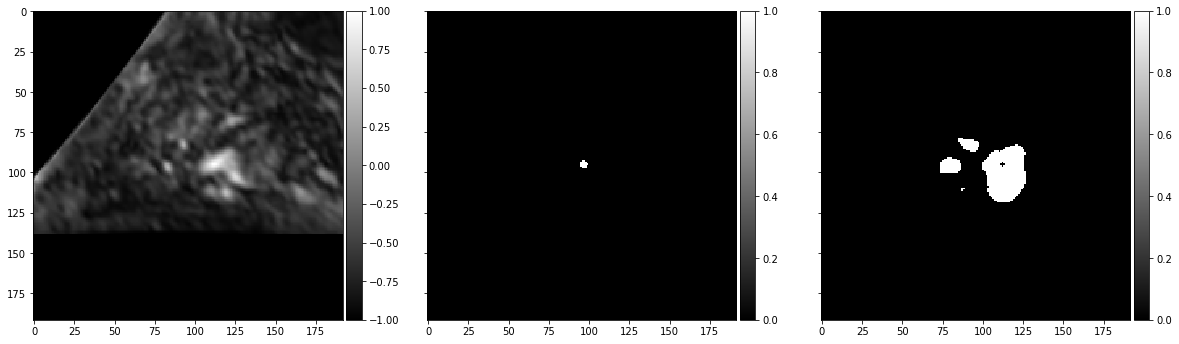

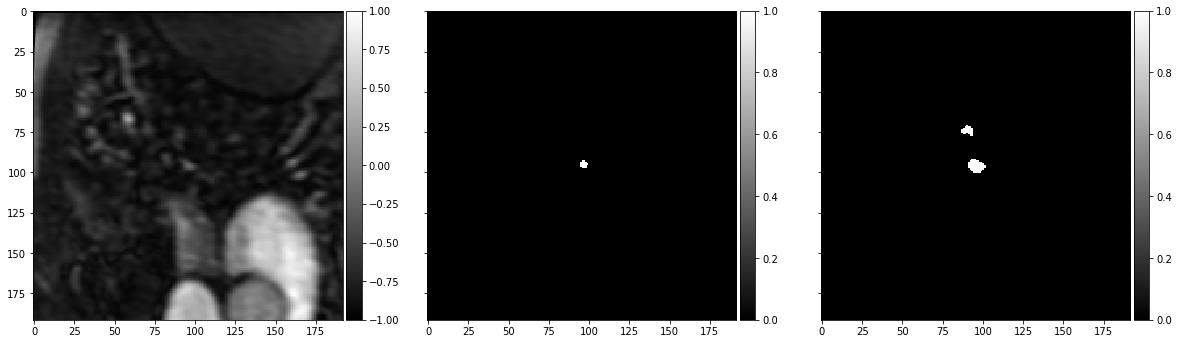

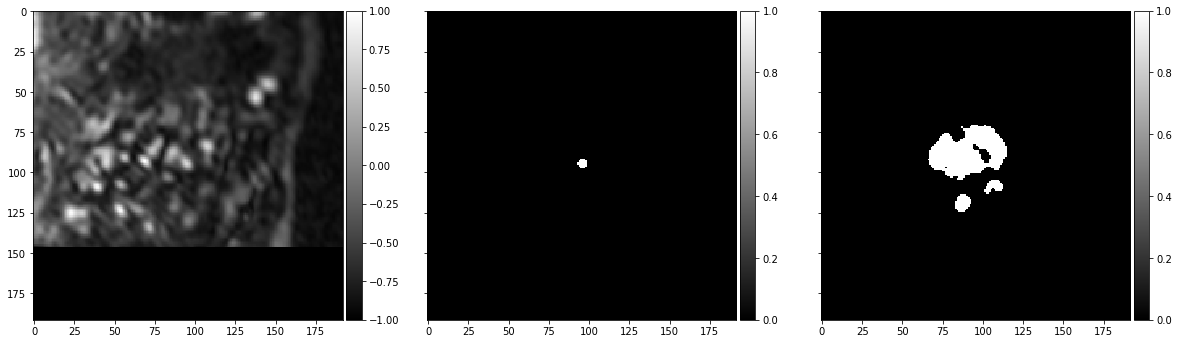

In [17]:
scale = 305.6
iter_ = 100
alpha = 4.0
R = 30
mu = 0.2
sig = 0.5
lamda = 2.0

for i in range(7):
    j = np.random.randint(N)
    im = f_train.root.X[j,:,:,0].astype(float)
    truth = f_train.root.Y[j,:,:,0].astype(float)
    seg,conts = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    implot(im,ax1)
    implot(truth,ax2)
    implot(seg,ax3)
    plt.tight_layout
    plt.show()

In [18]:
segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0]
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

0
1000
2000
3000
4000
5000
6000


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/marsdenlab/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/marsdenlab/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/marsdenlab/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/marsdenlab/anaconda2/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/marsdenlab/anaconda2/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/marsdenlab/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename

IndexError: string index out of range

In [ ]:
np.save('drls_segs_{}.npy'.format(CODE),segs)
np.save('drls_conts_{}.npy'.format(CODE),conts)

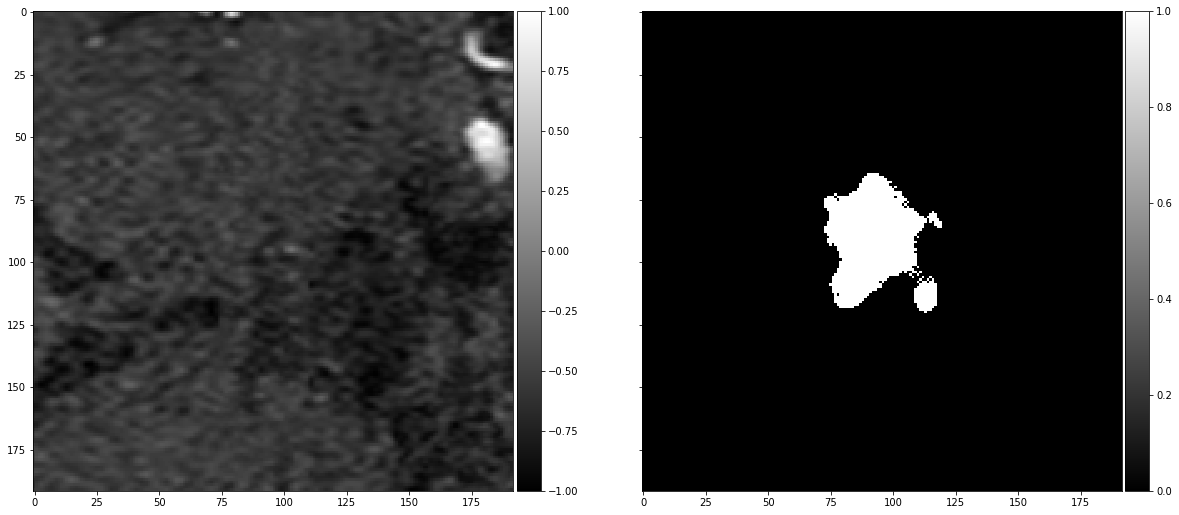

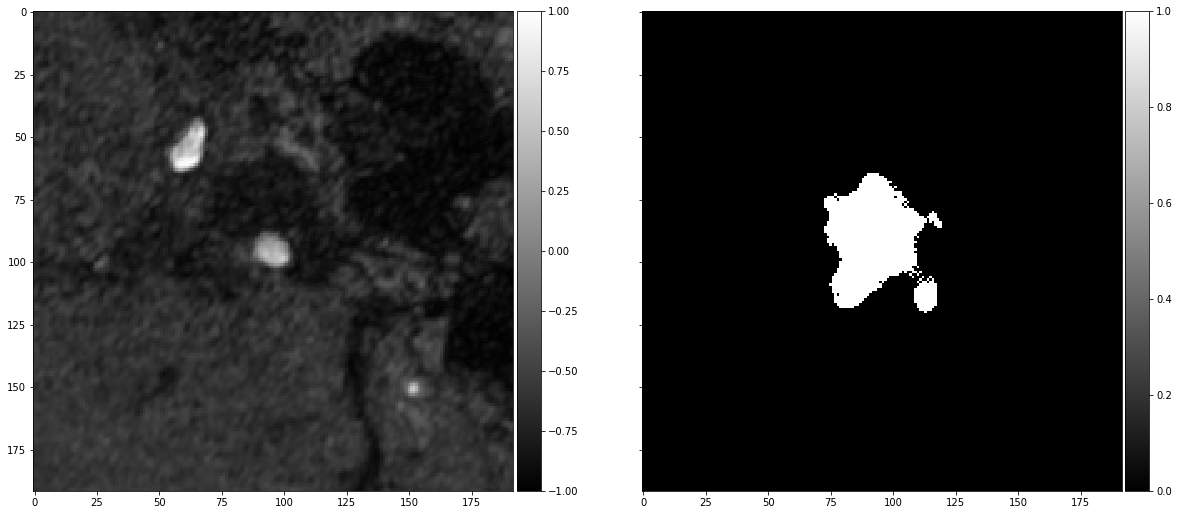

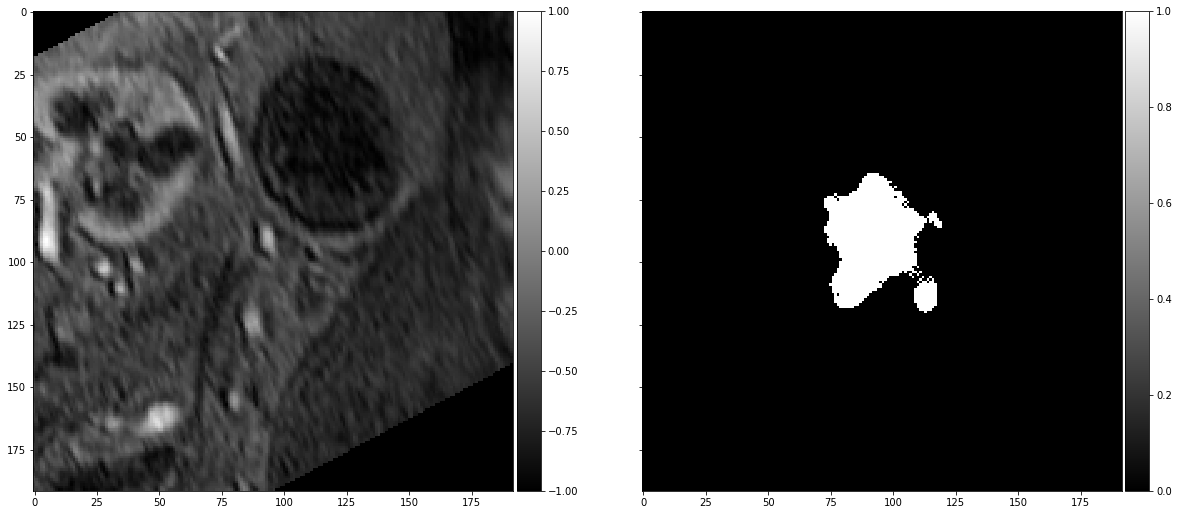

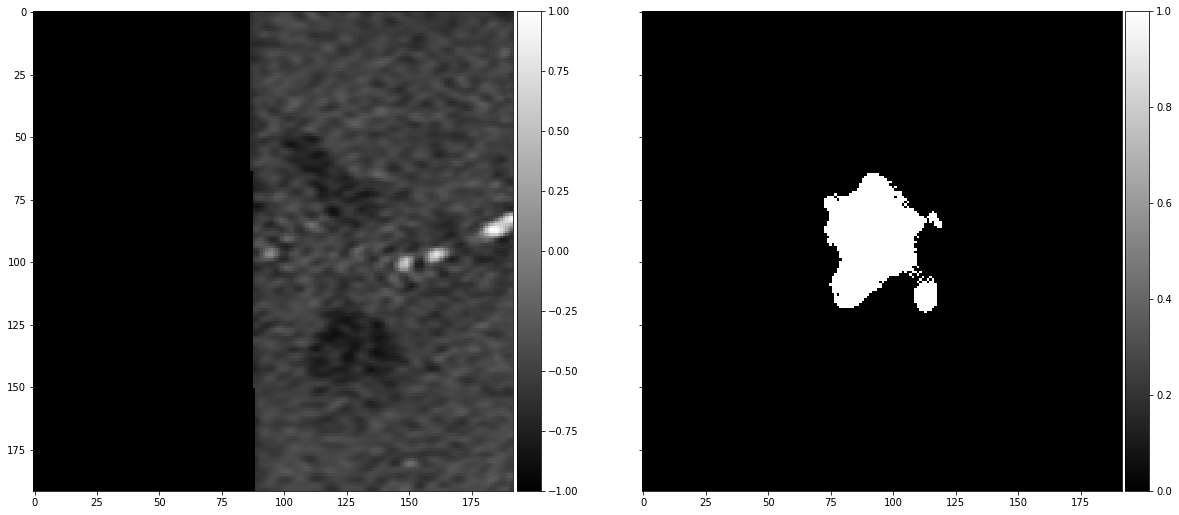

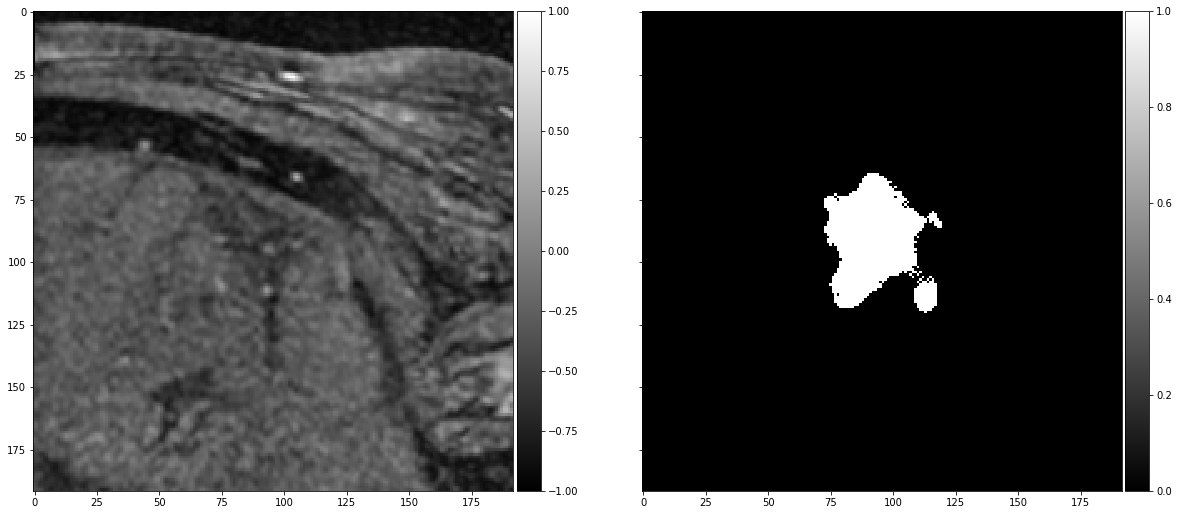

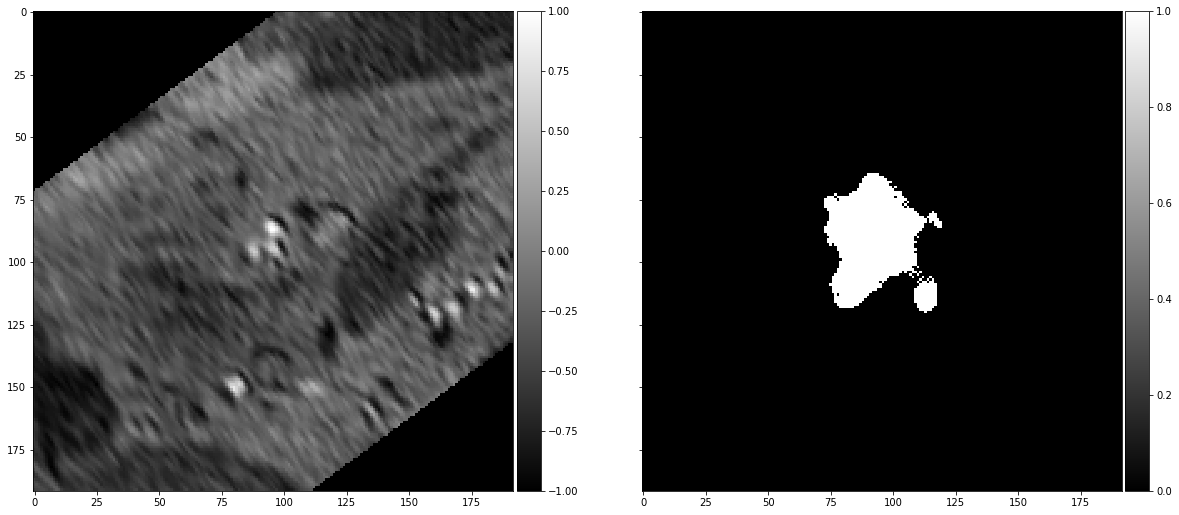

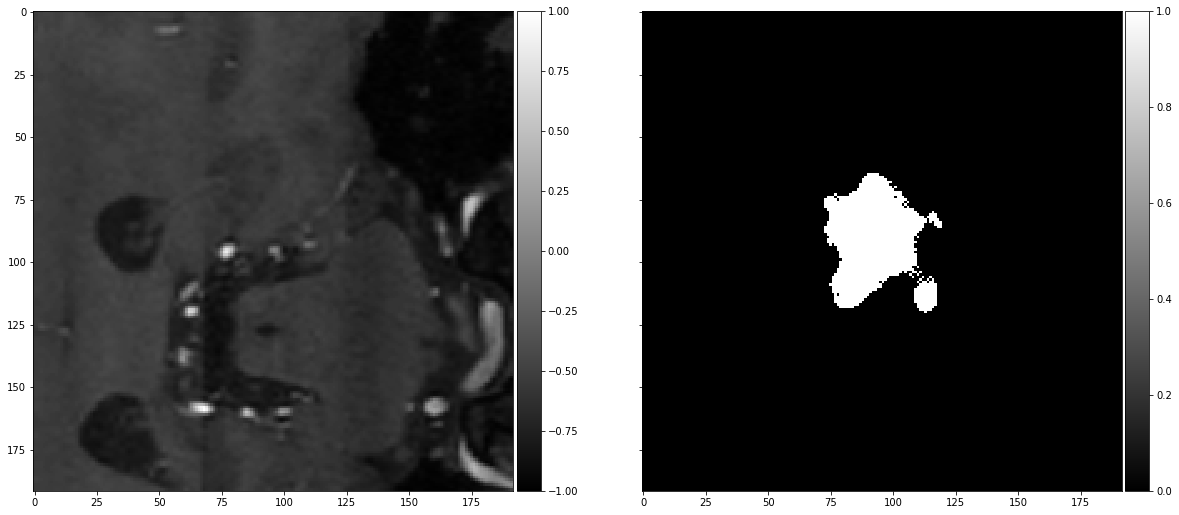

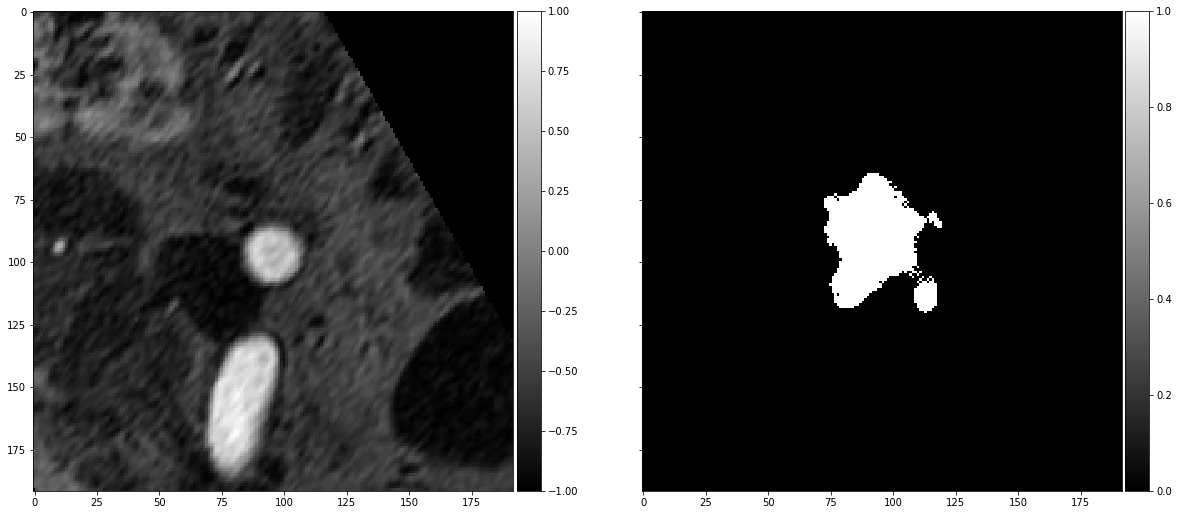

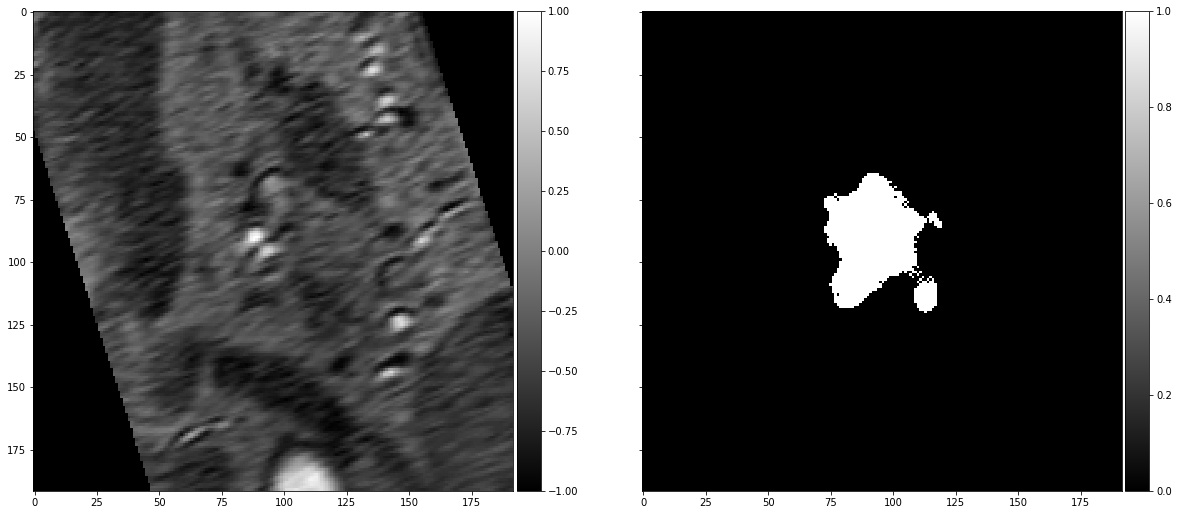

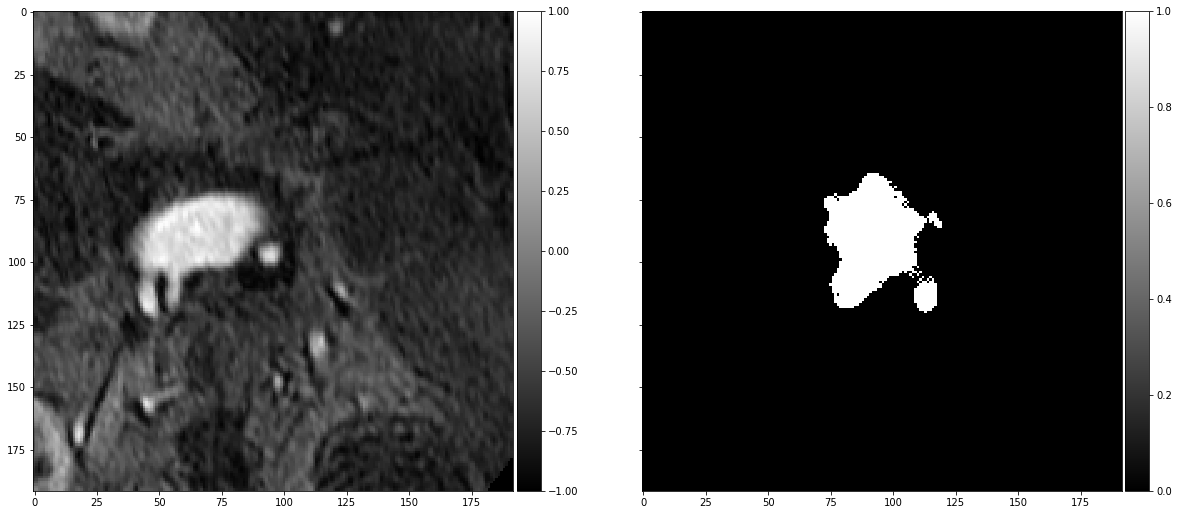

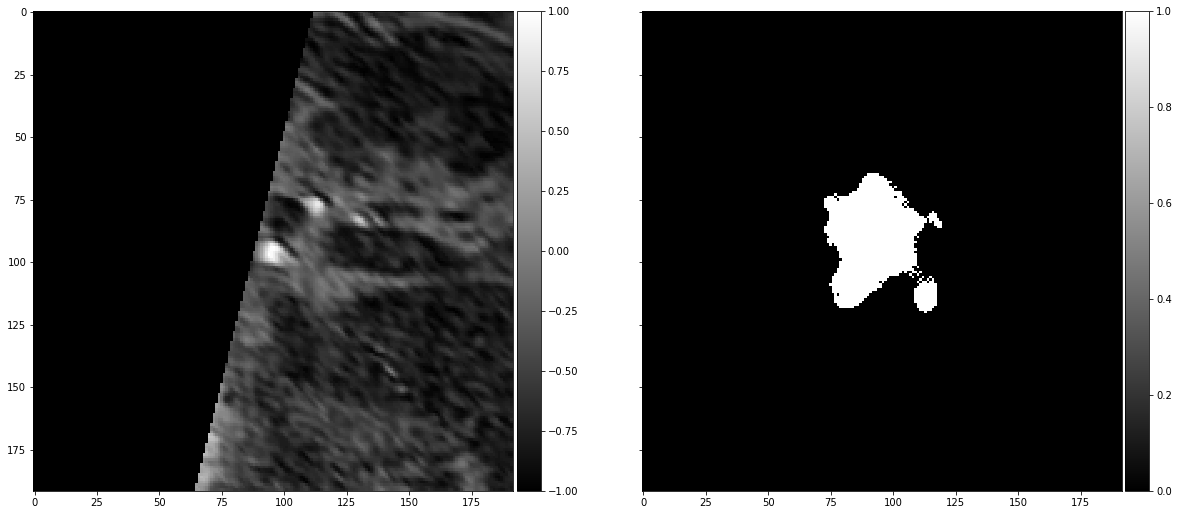

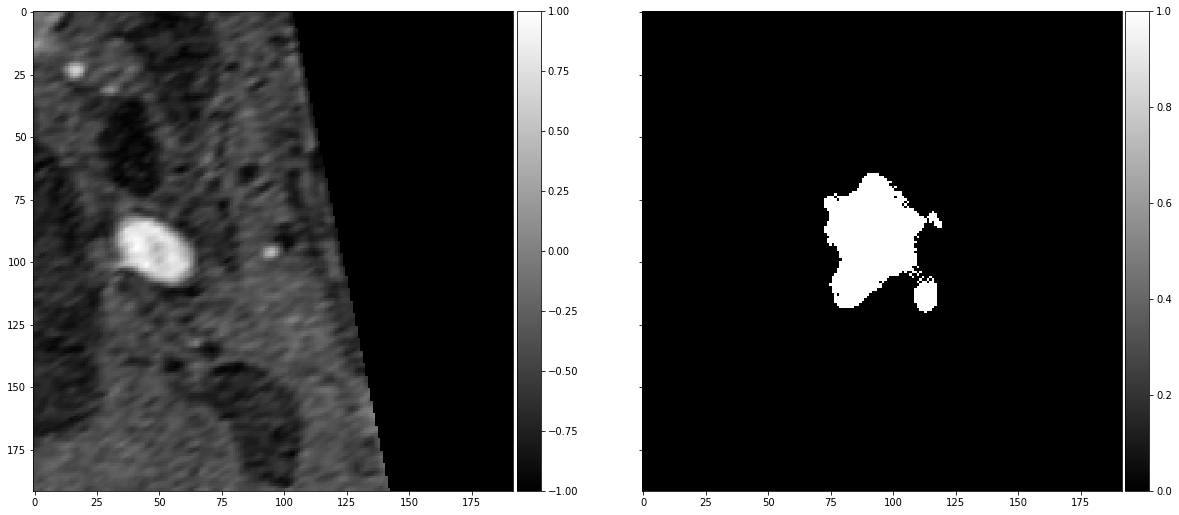

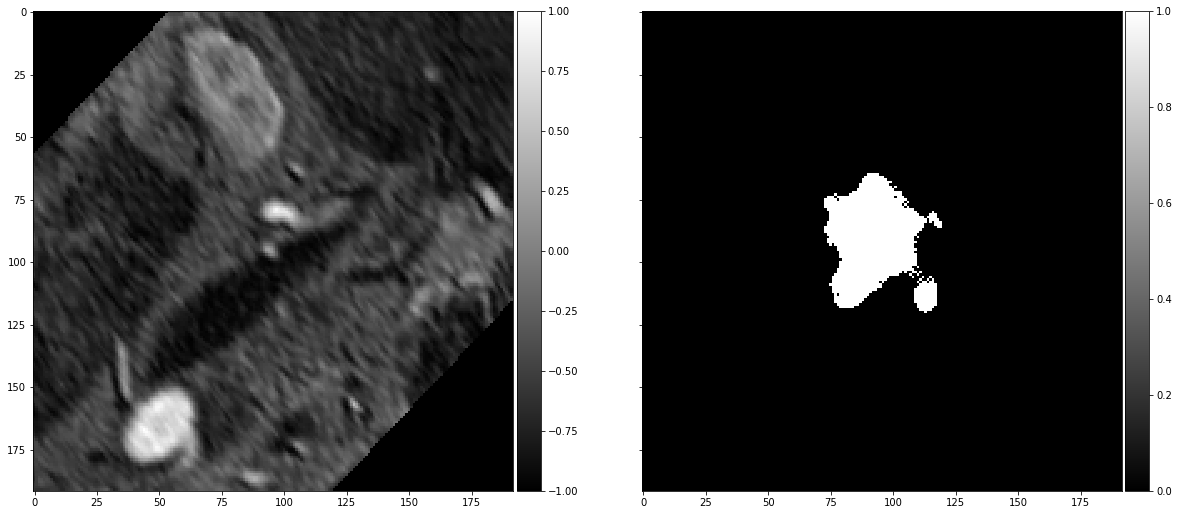

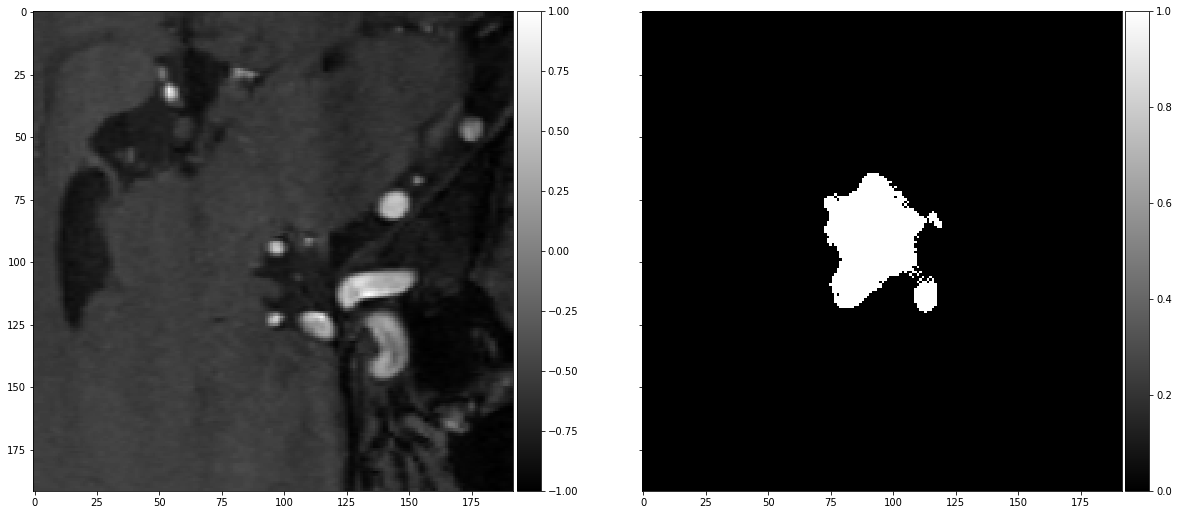

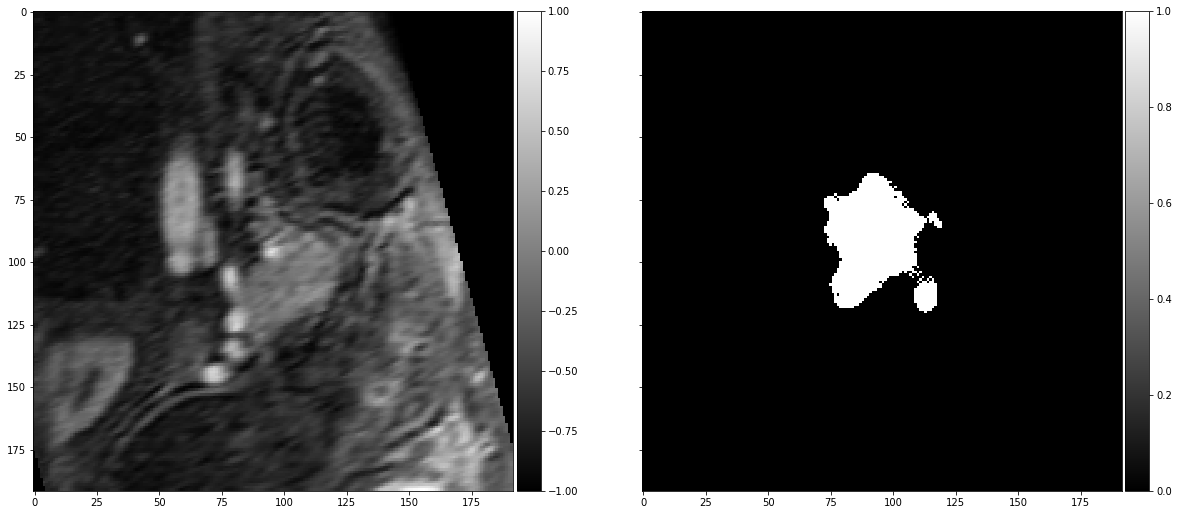

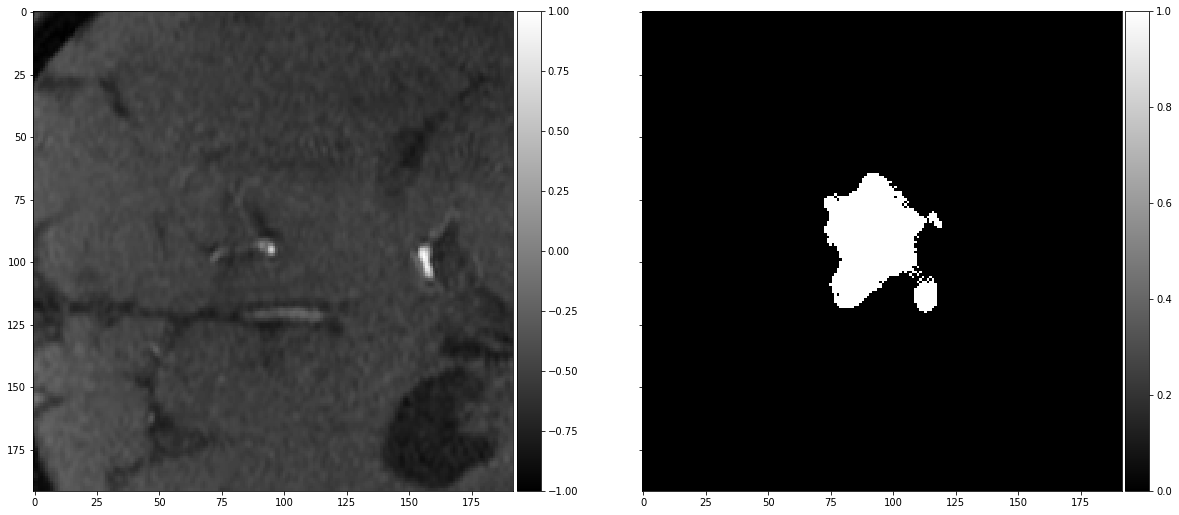

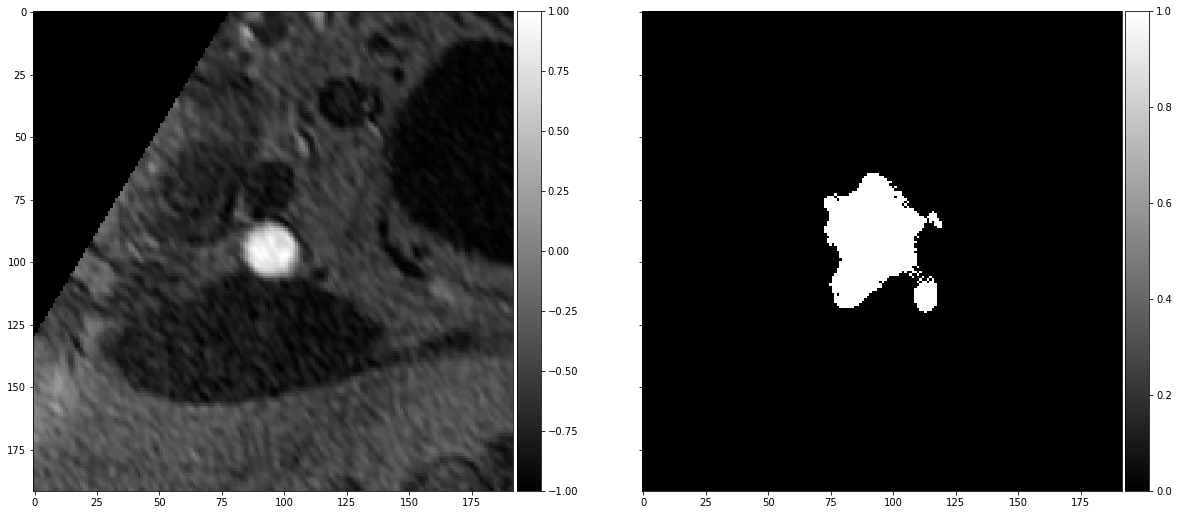

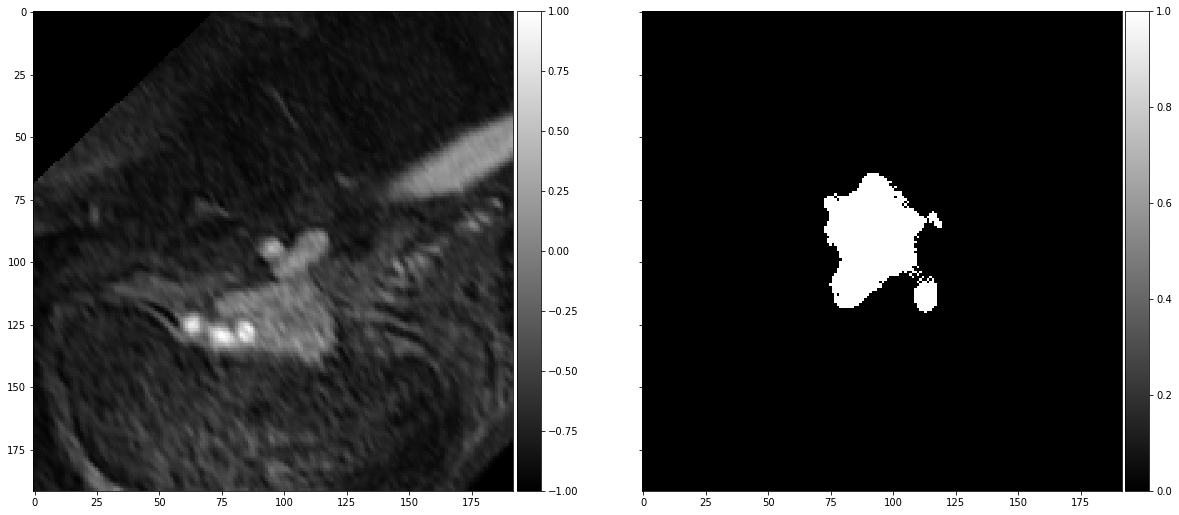

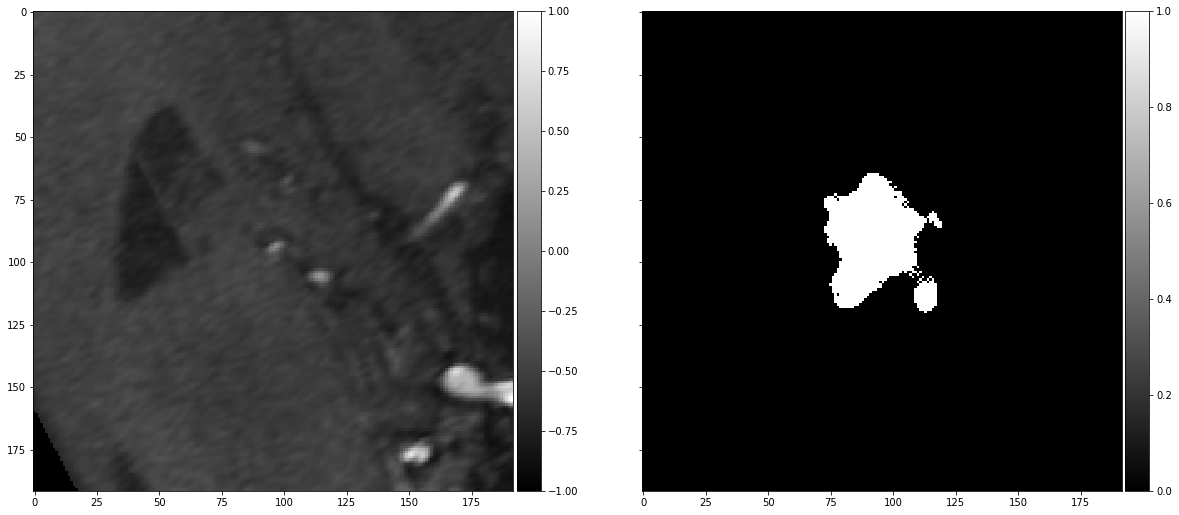

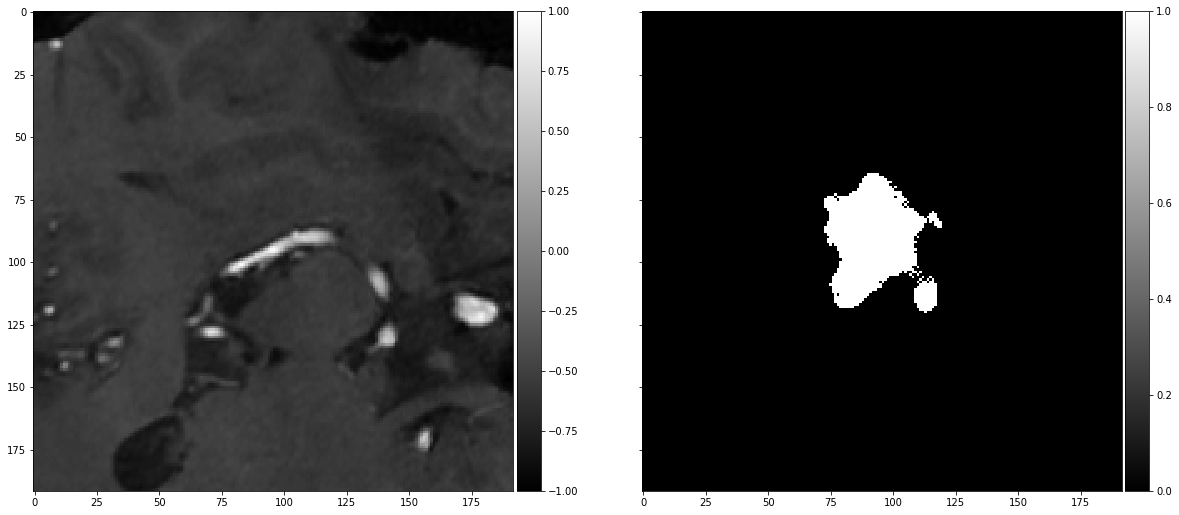

In [51]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(20):
    j = np.random.randint(N)
    im = f_test.root.X[j,:,:,0].astype(float)
    seg = segs[j,:,:].astype(float)
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(im,ax1)
    implot(seg,ax2)
    plt.tight_layout
    plt.show()

In [10]:
#mr data
CODE ='OOF'
oof_test_mr = data_path+'test_192_mr_oof.hdf5'
oof_test_ct = data_path+'test_192_ct_oof.hdf5'

f_mr = tables.open_file(oof_test_mr)
f_ct = tables.open_file(oof_test_ct)



In [12]:
# mu = 0.3
# lamda = 1.5
# alpha = 0.6
# R = 40

X = f_ct.root.X
Y = f_ct.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0].astype(np.float32)
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

(20463, 192, 192, 1)
(20463, 192, 192, 1)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [ ]:
np.save('drls_segs_{}_ct.npy'.format(CODE),segs)
np.save('drls_conts_{}_ct.npy'.format(CODE),conts)

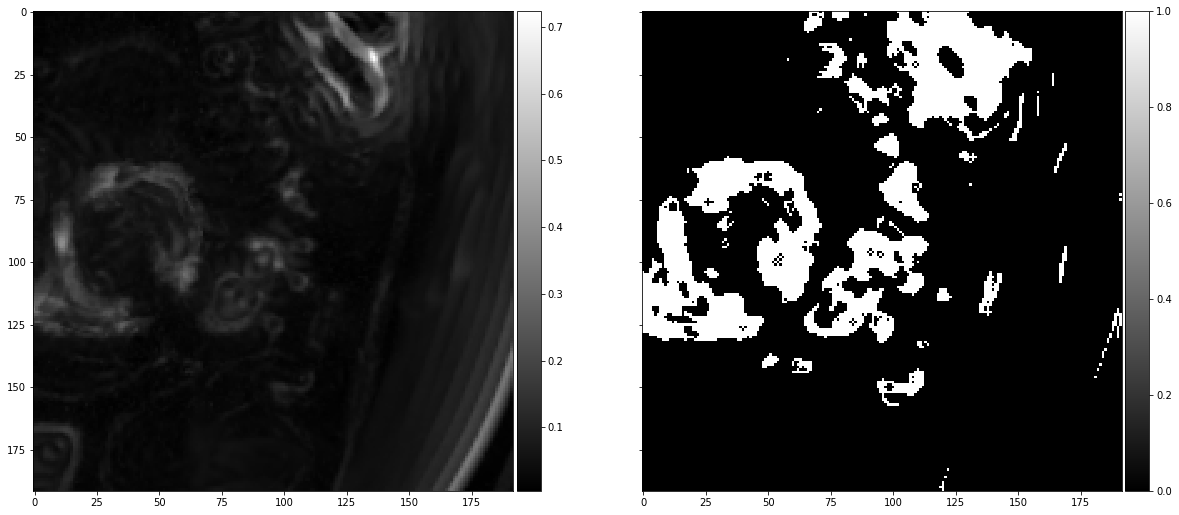

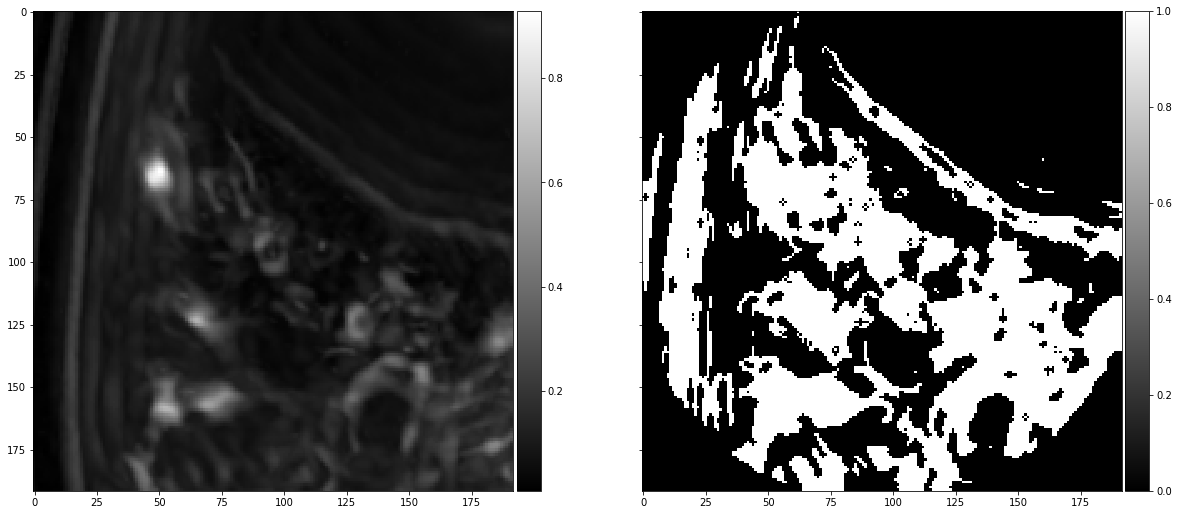

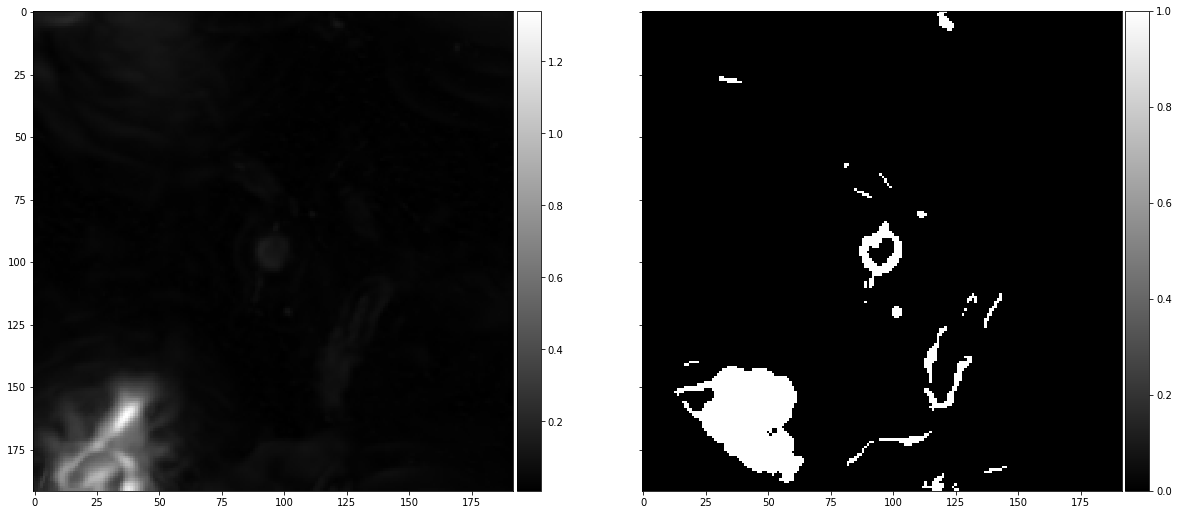

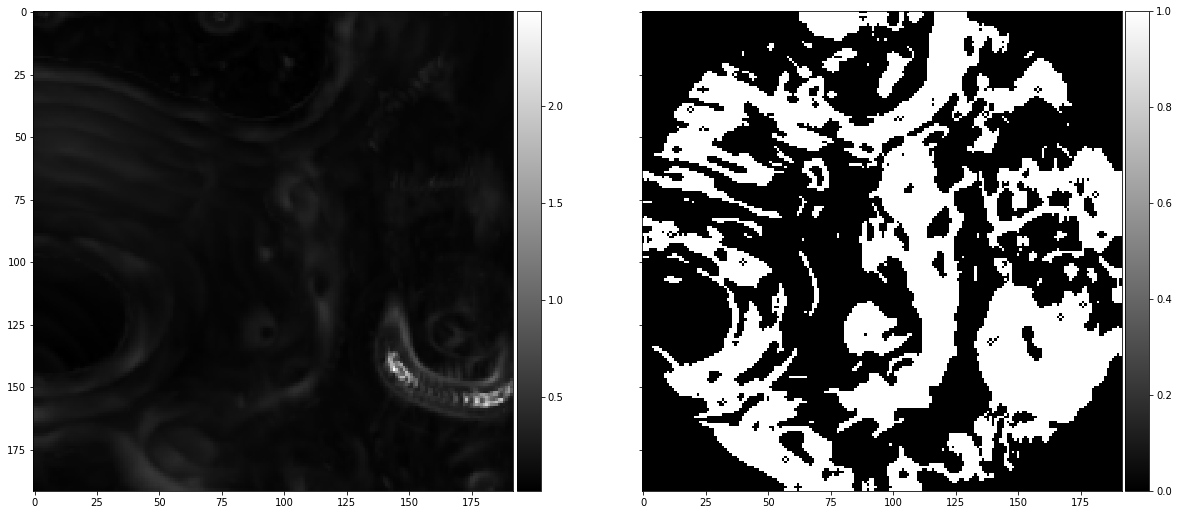

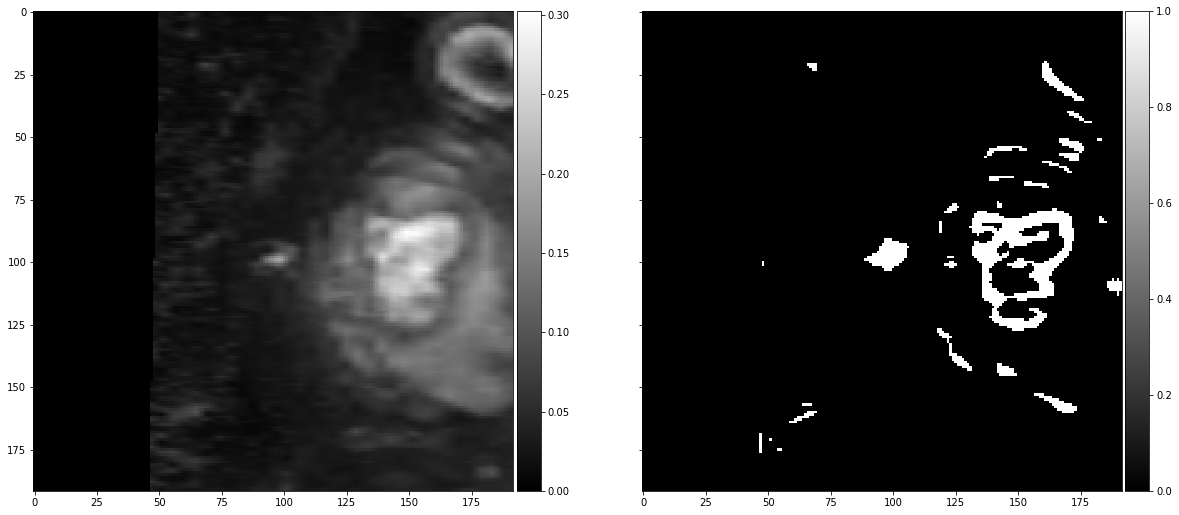

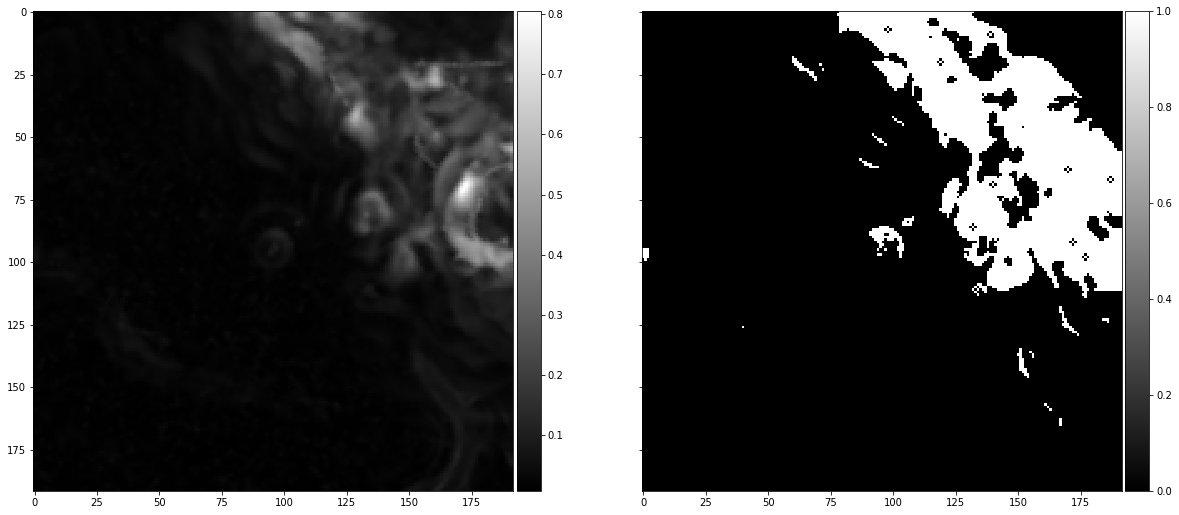

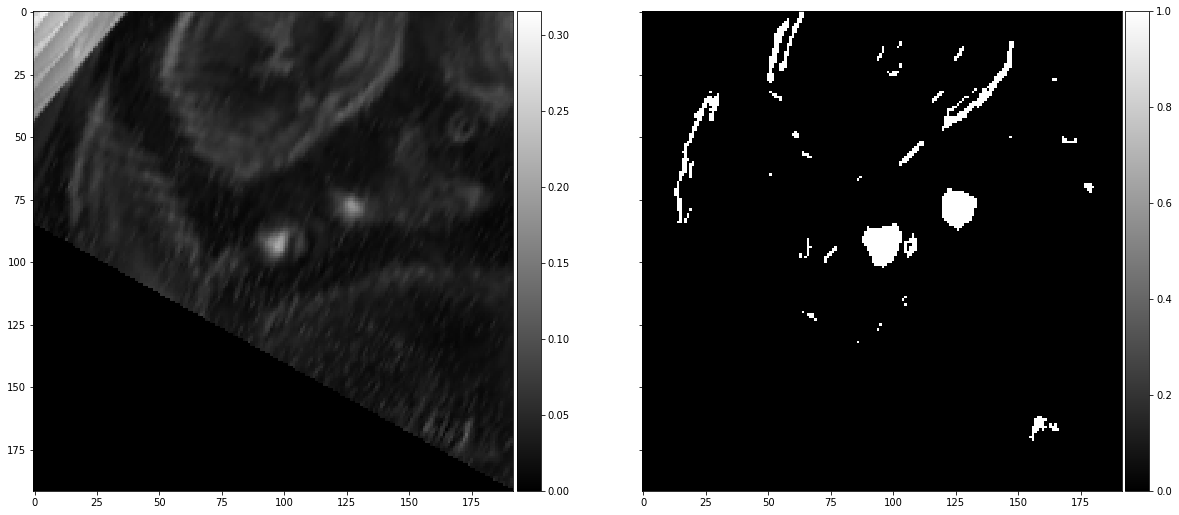

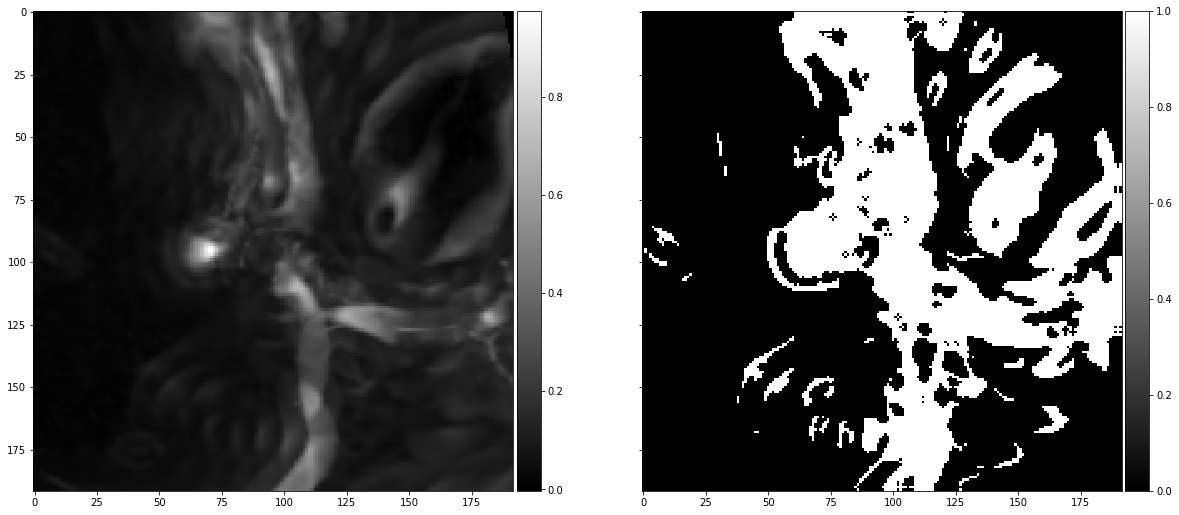

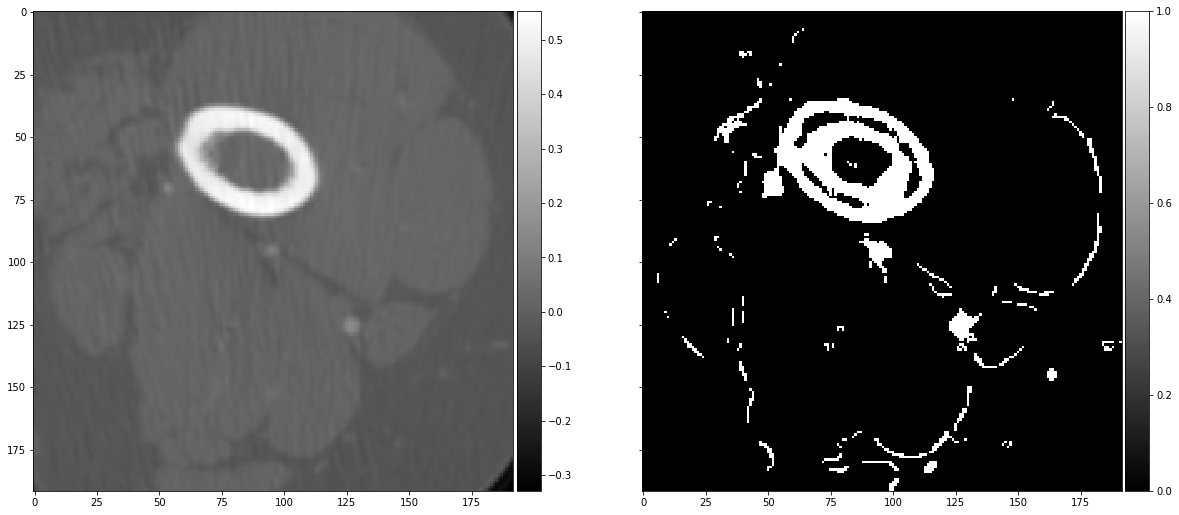

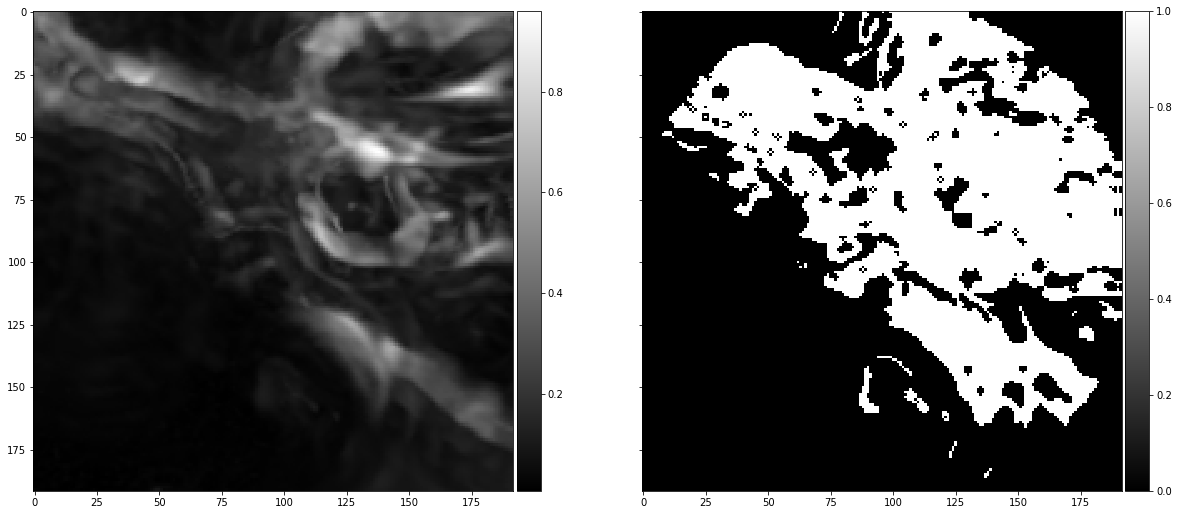

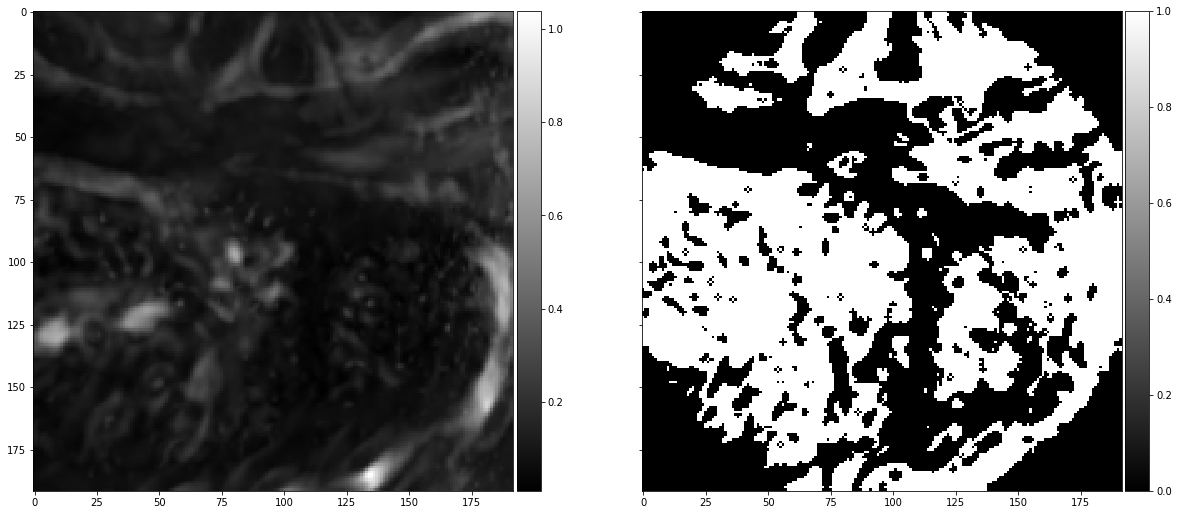

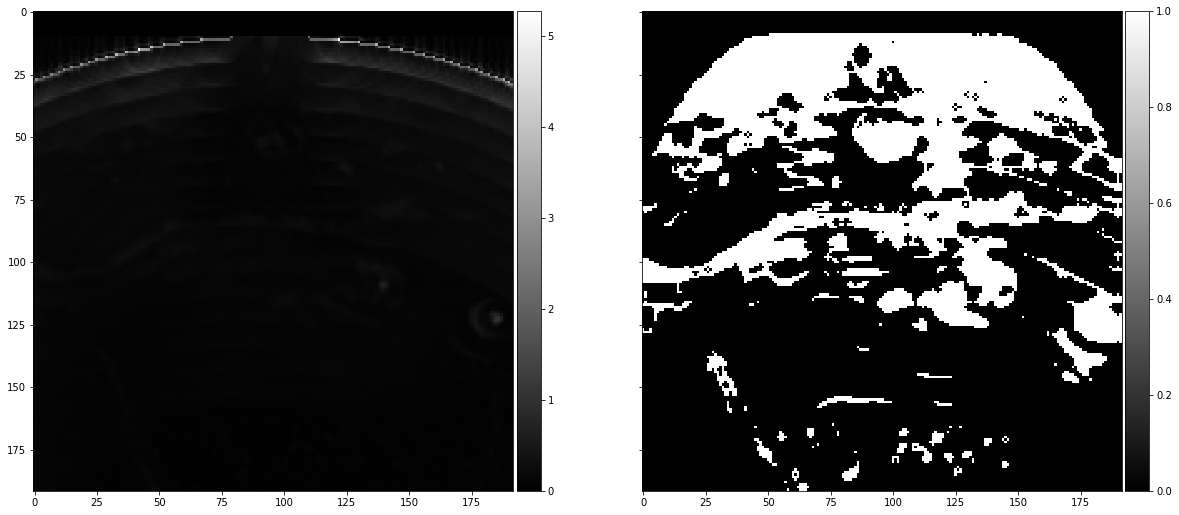

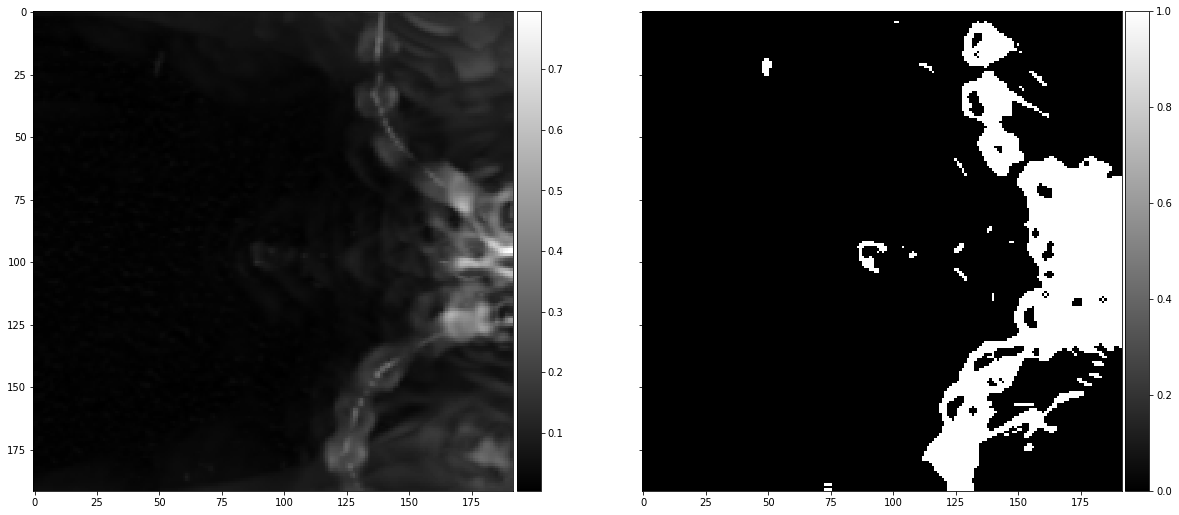

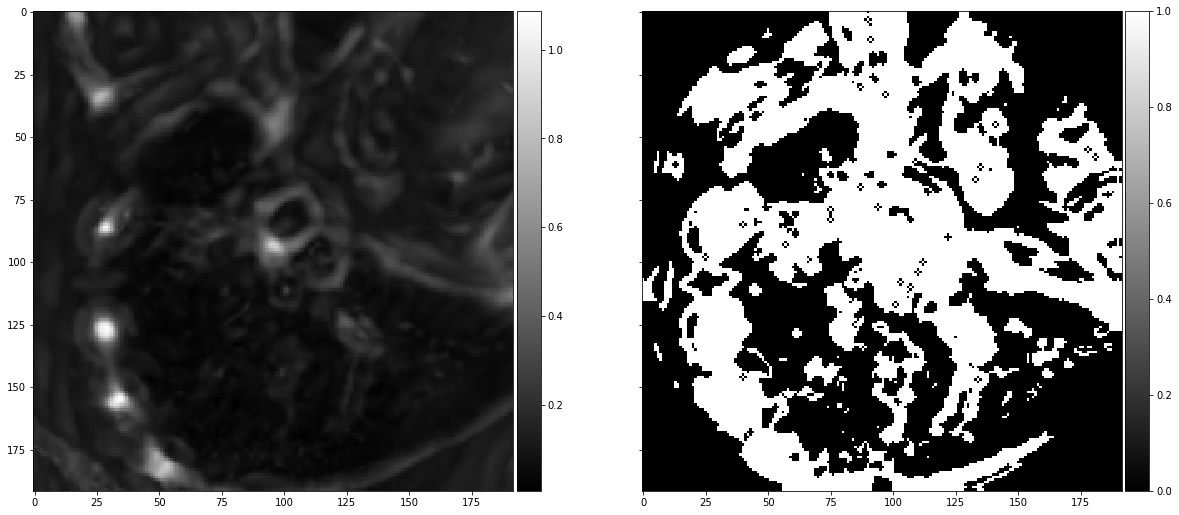

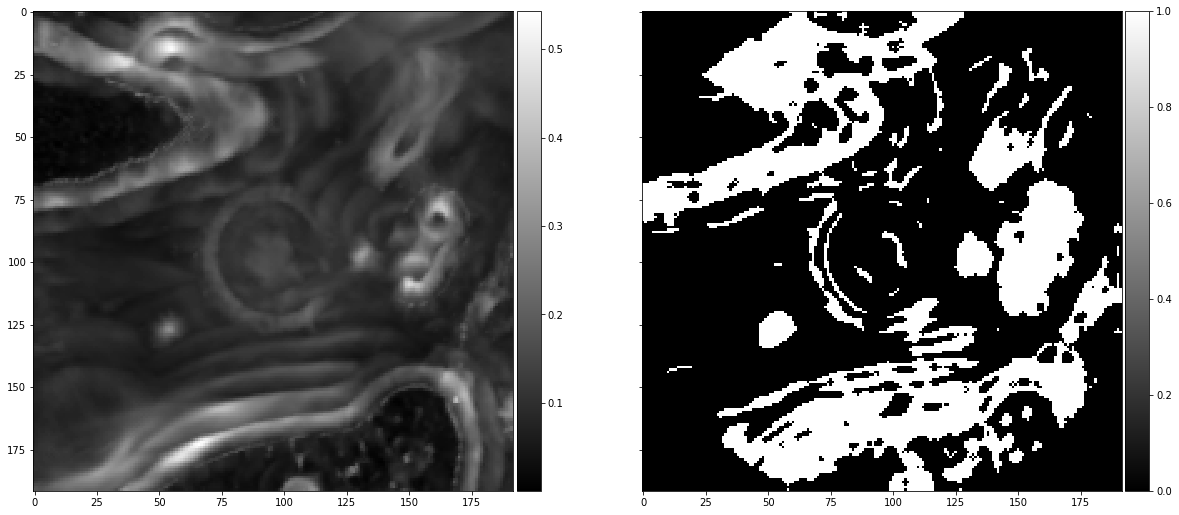

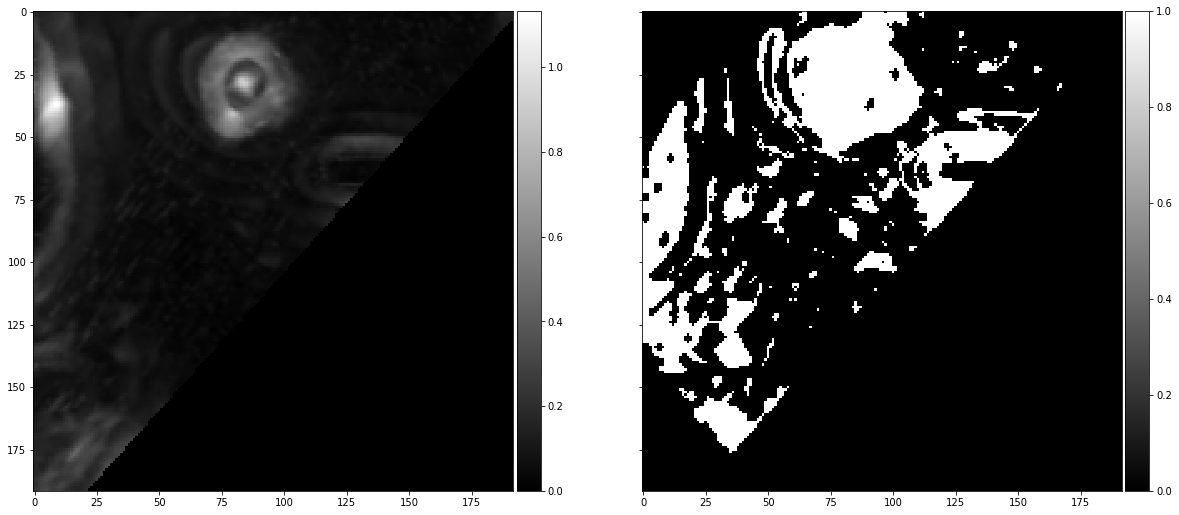

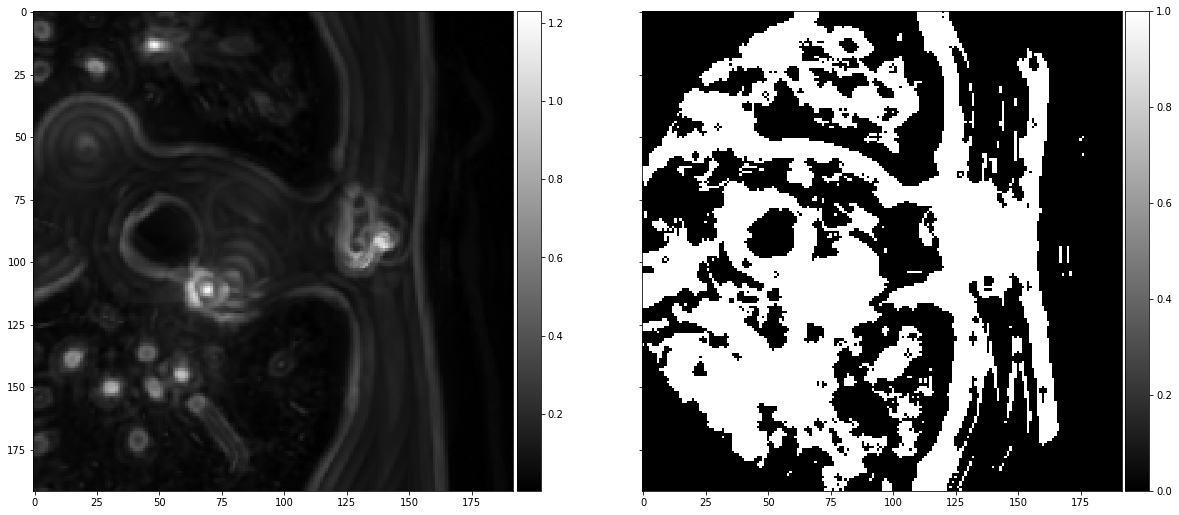

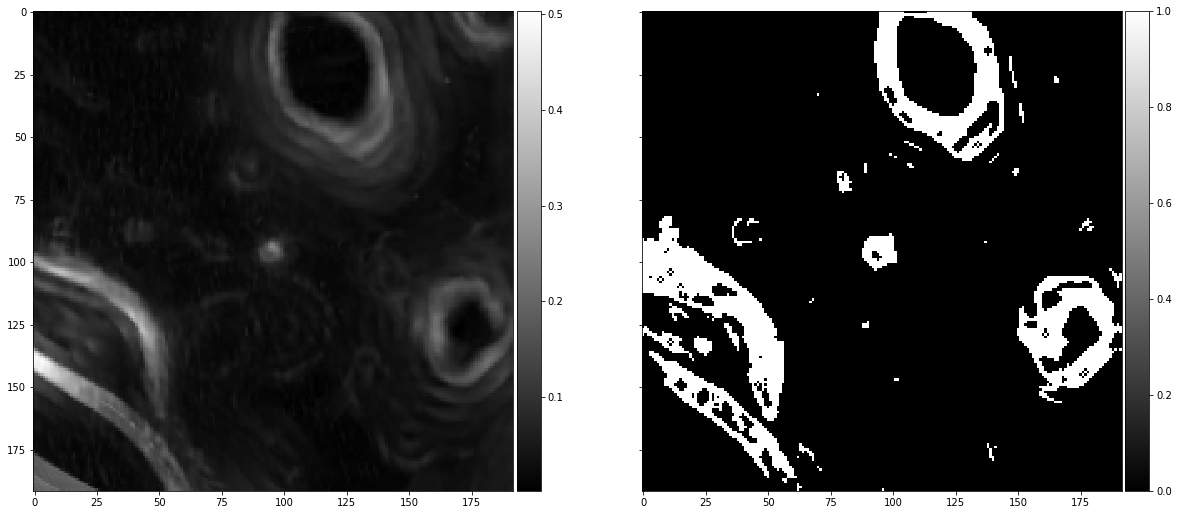

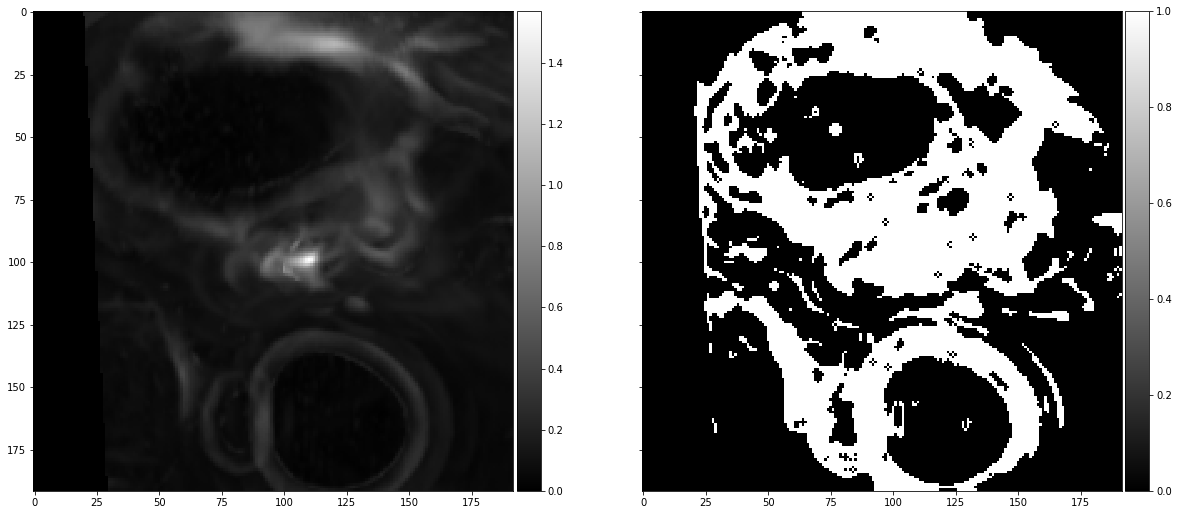

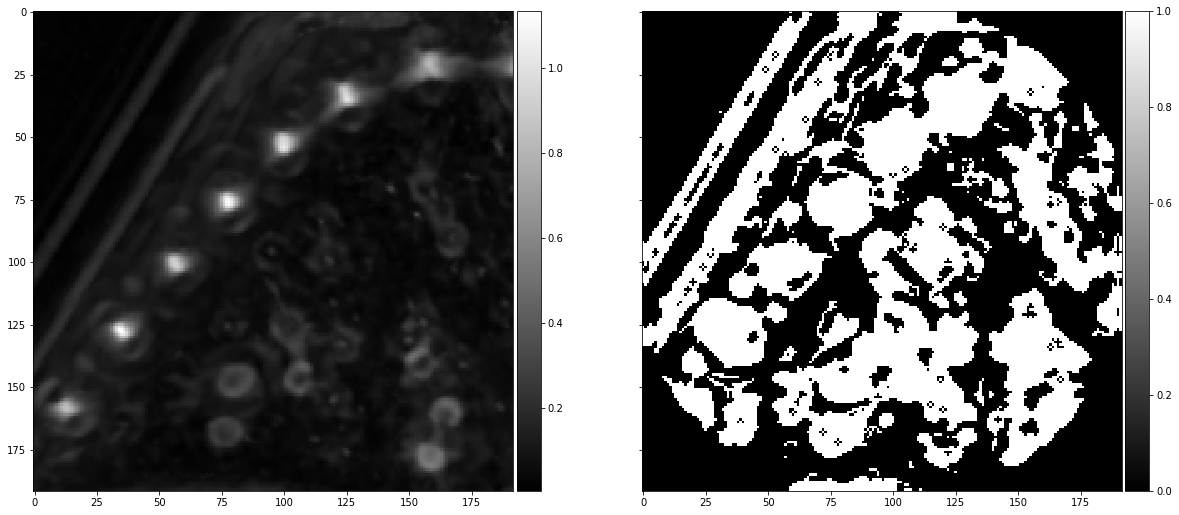

In [59]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(20):
    j = np.random.randint(N)
    im = X[j,:,:,0].astype(float)
    seg,cont = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(im,ax1)
    implot(seg,ax2)
    plt.tight_layout
    plt.show()

In [ ]:
# mu = 0.3
# lamda = 1.5
# alpha = 0.5
# R = 40

X = f_mr.root.X
Y = f_mr.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0]
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

In [ ]:
np.save('drls_segs_{}_mr.npy'.format(CODE),segs)
np.save('drls_conts_{}_mr.npy'.format(CODE),conts)

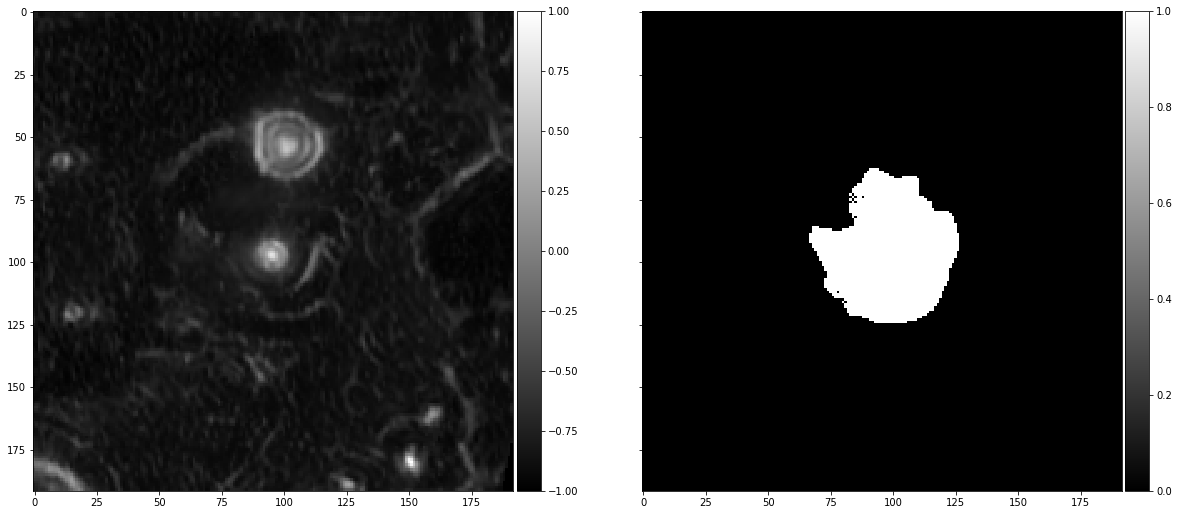

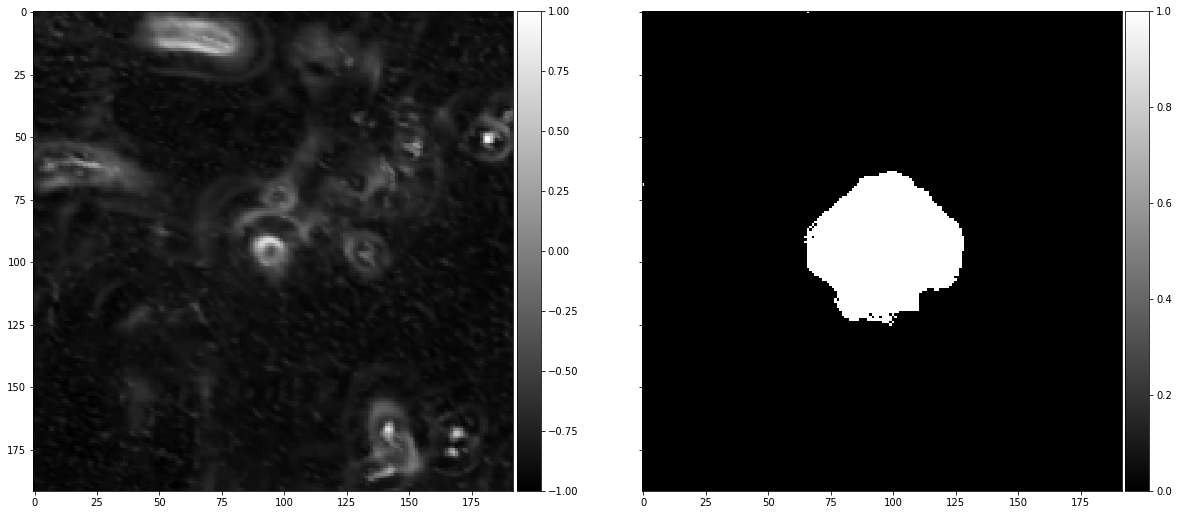

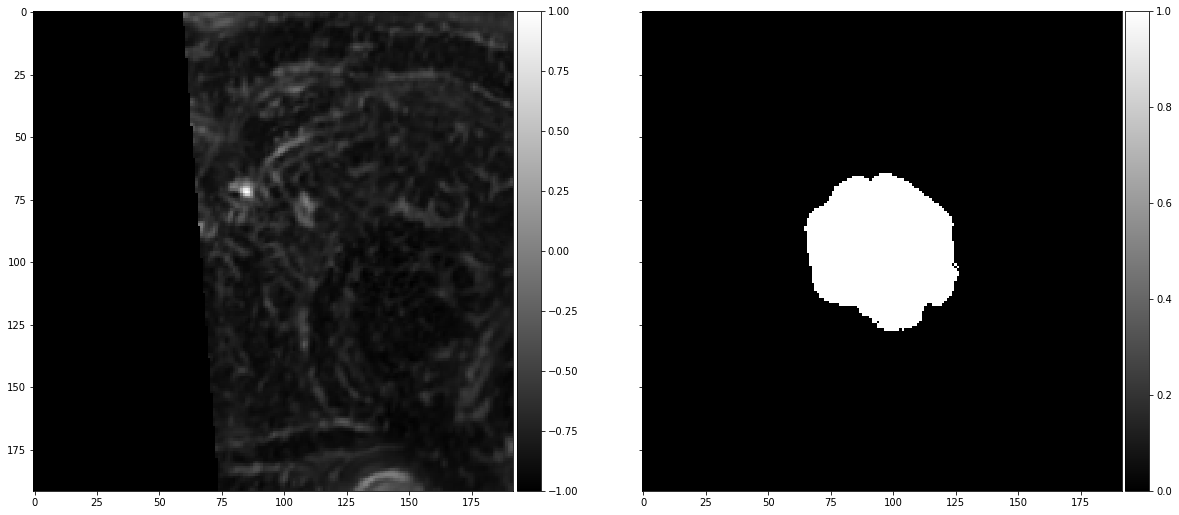

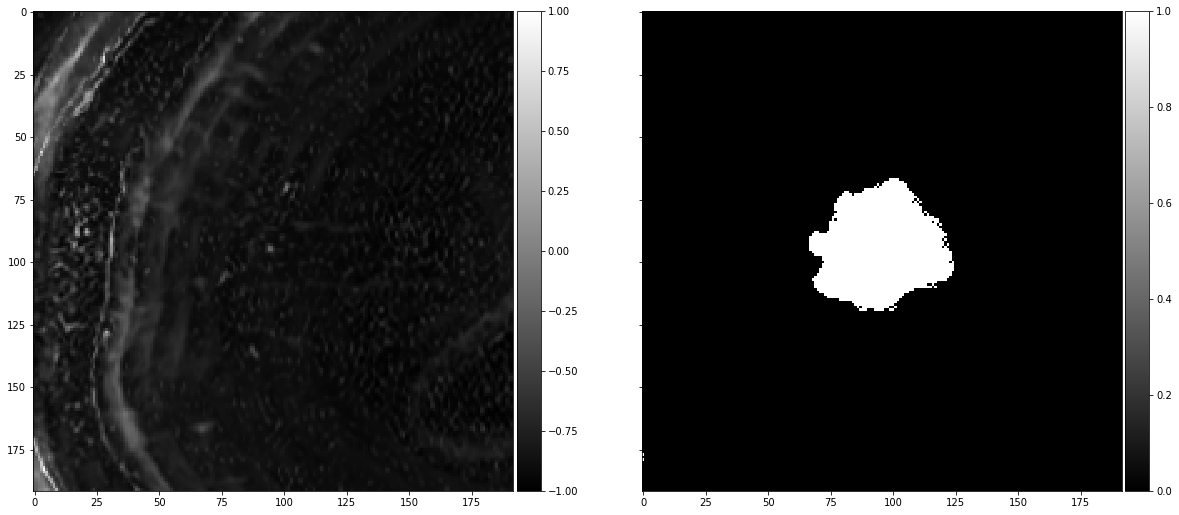

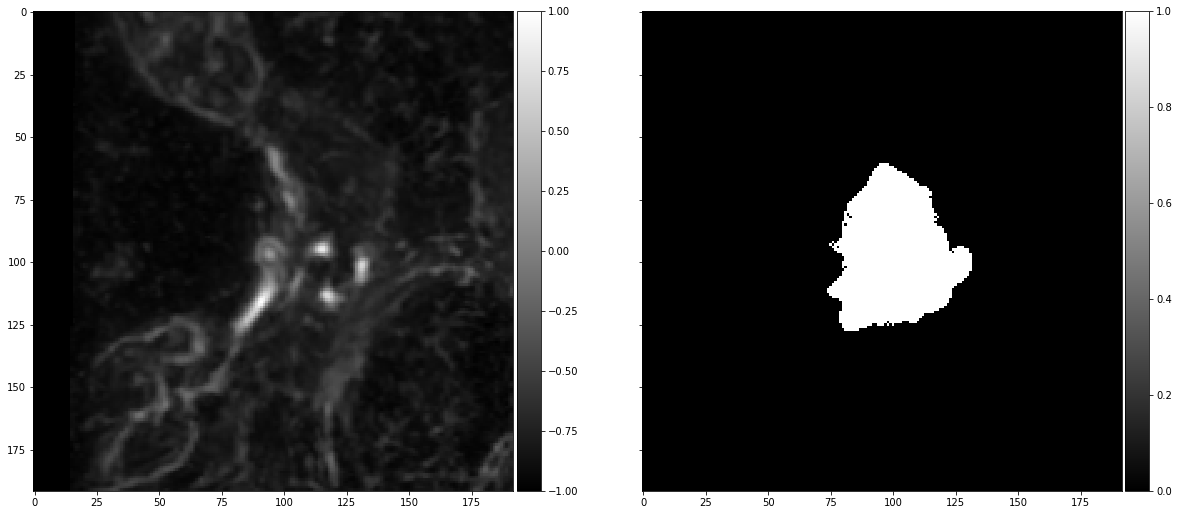

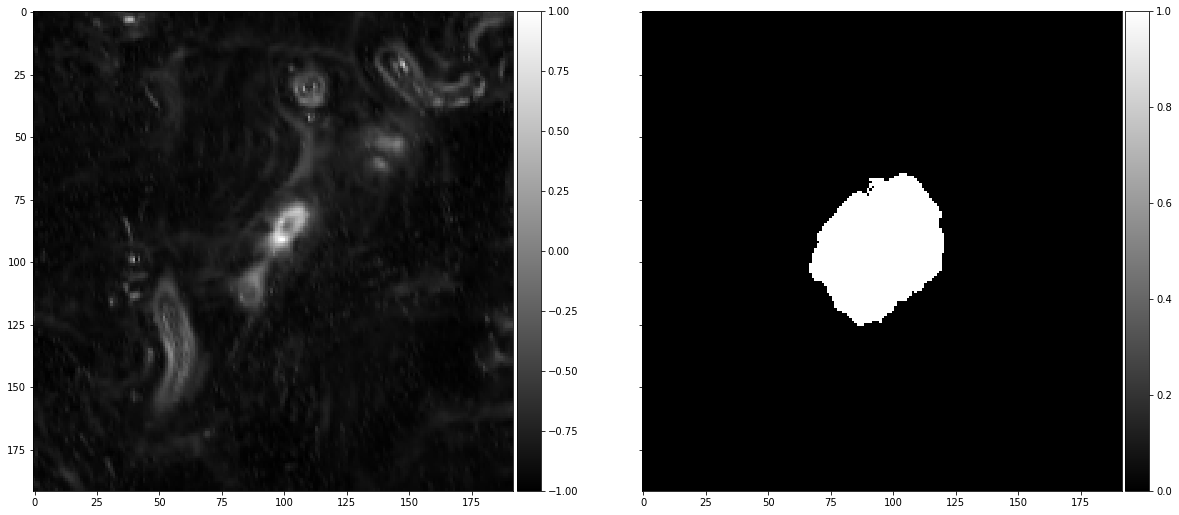

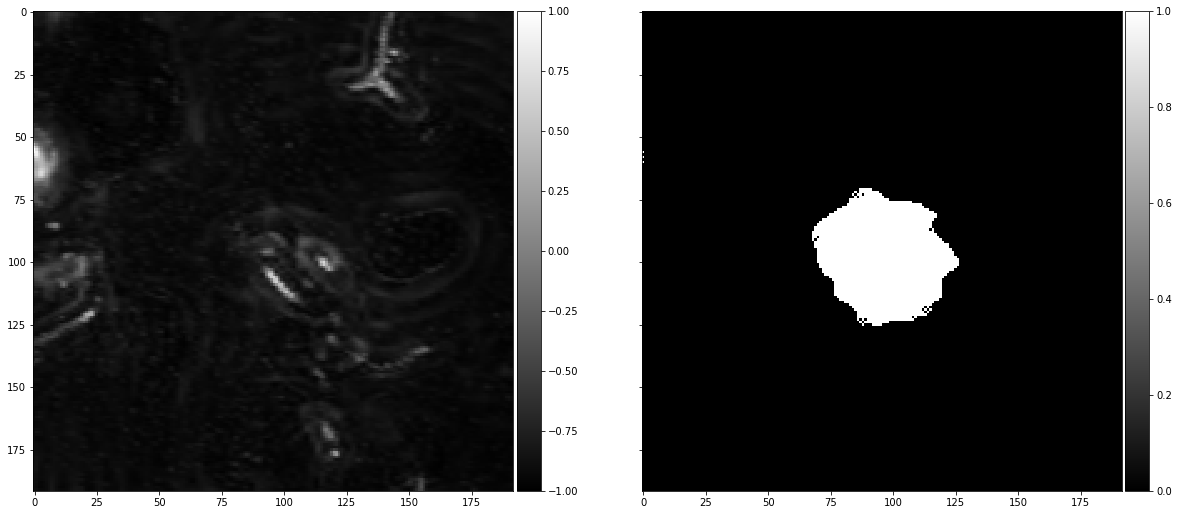

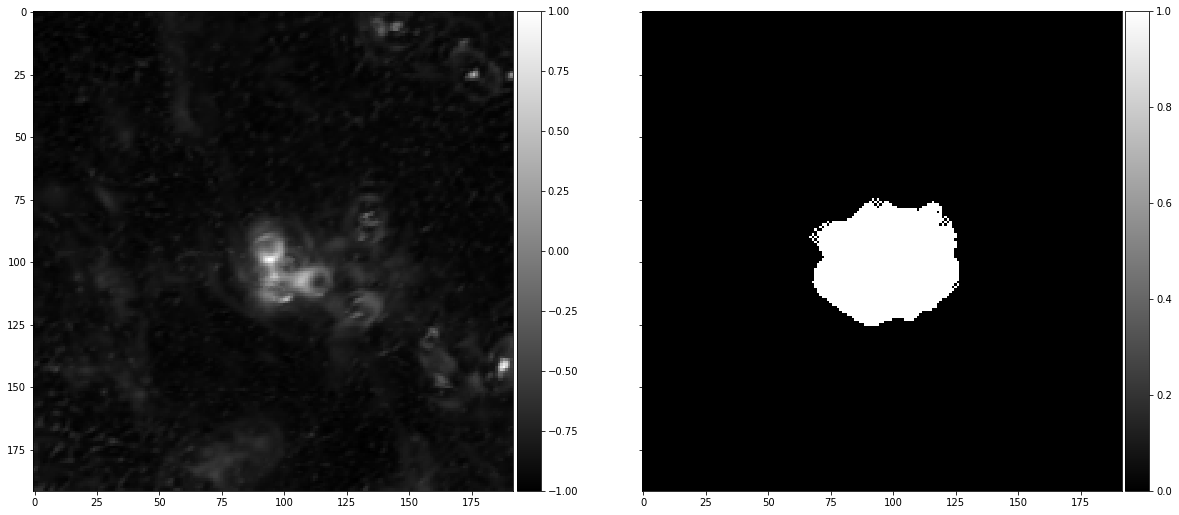

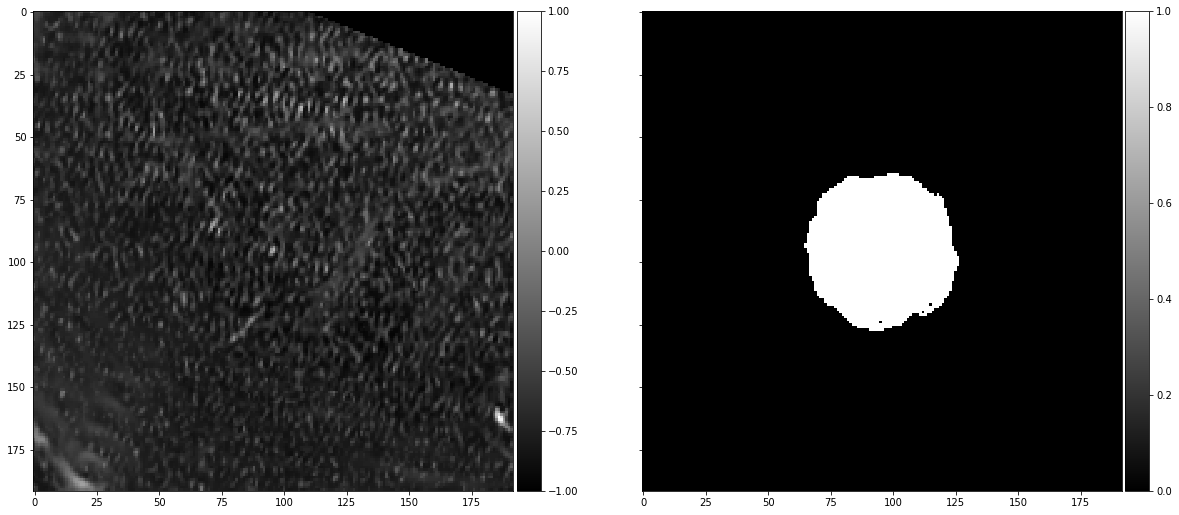

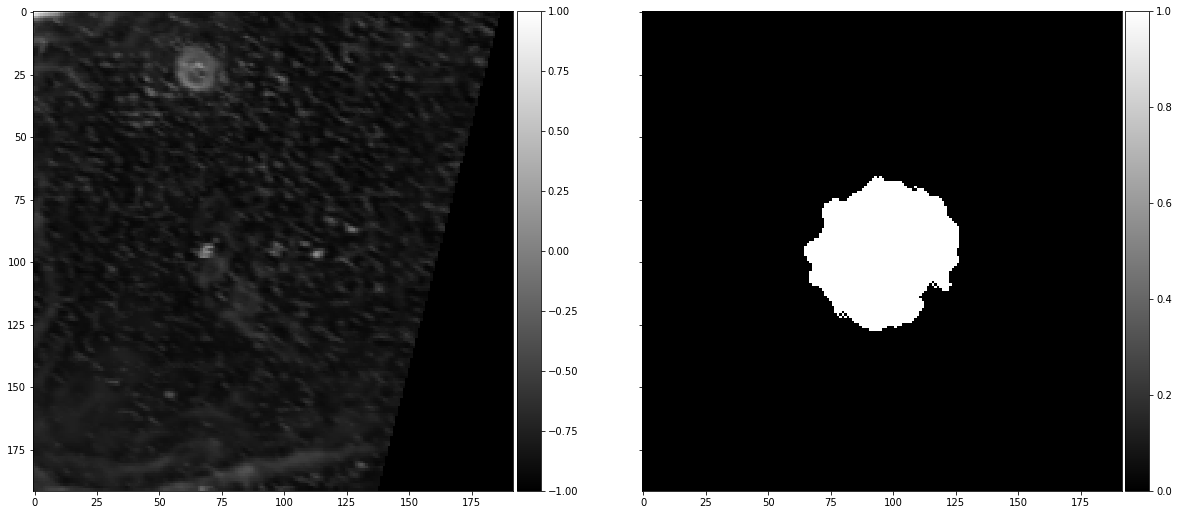

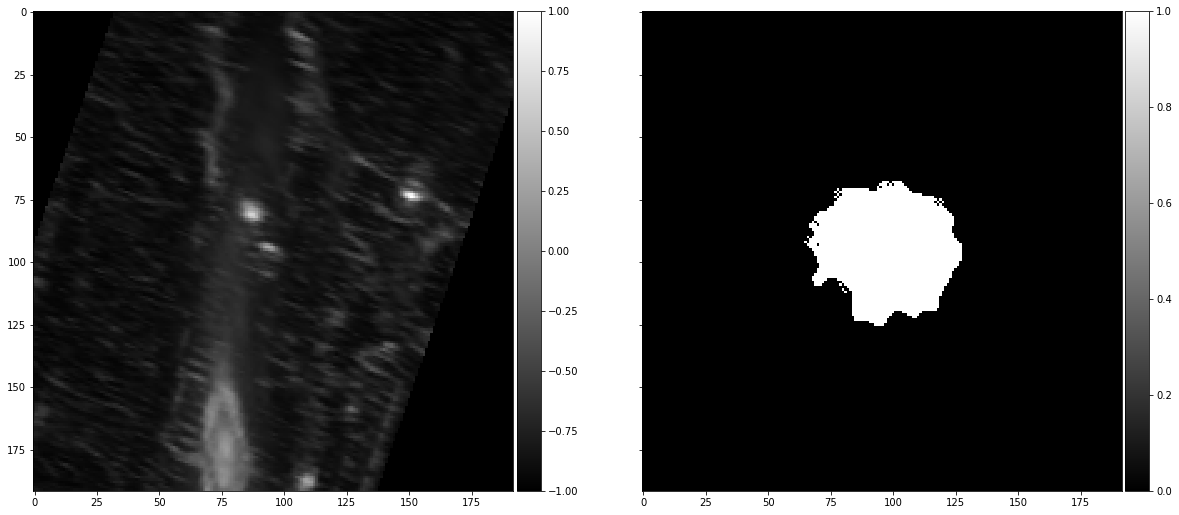

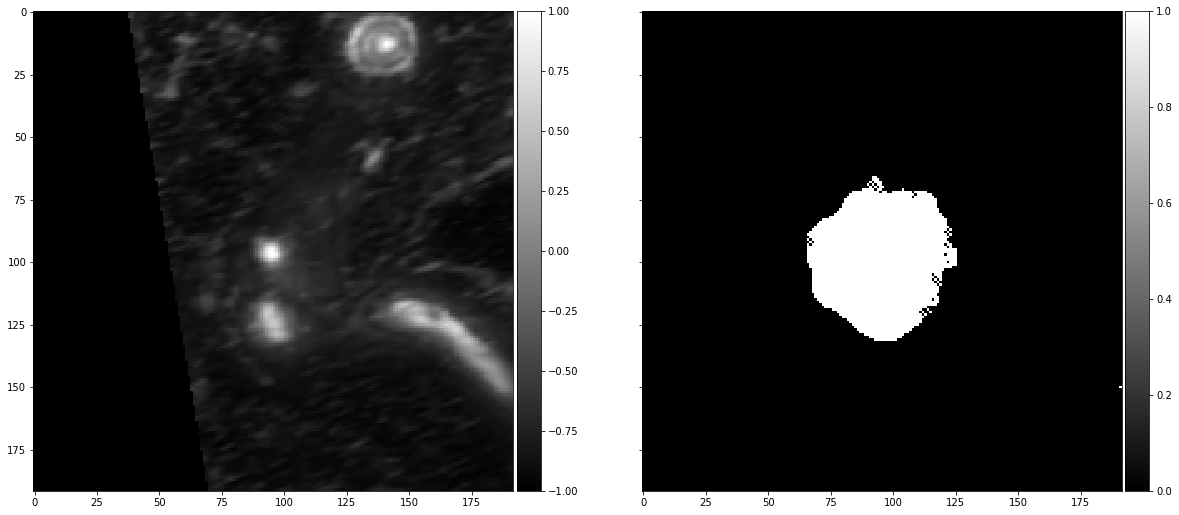

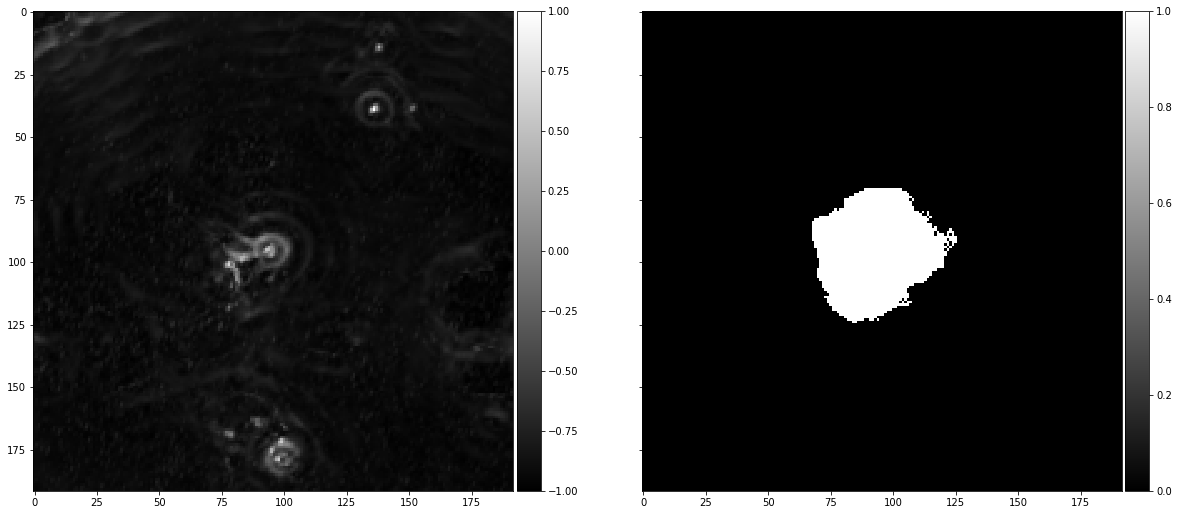

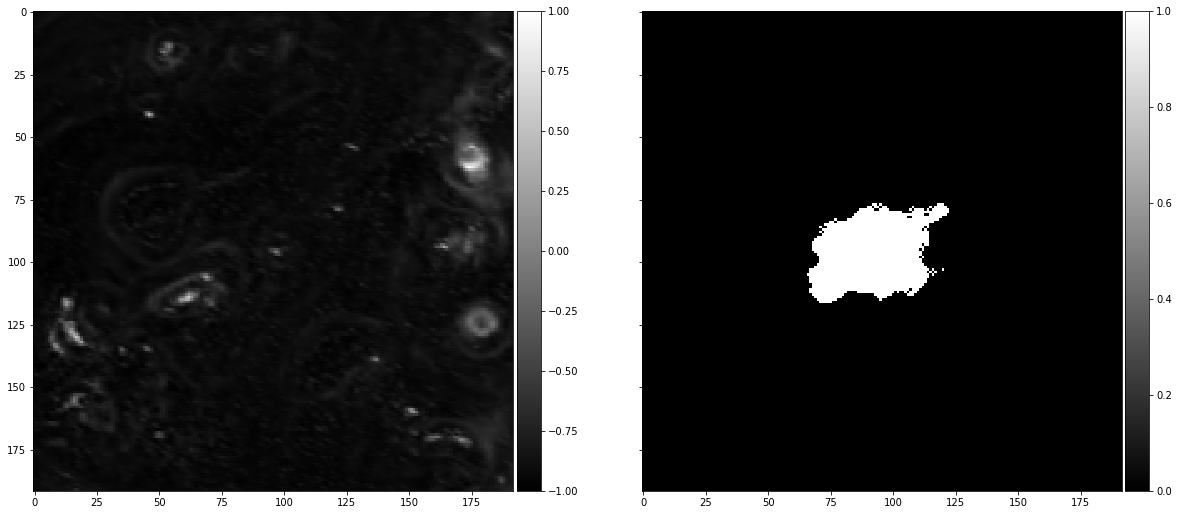

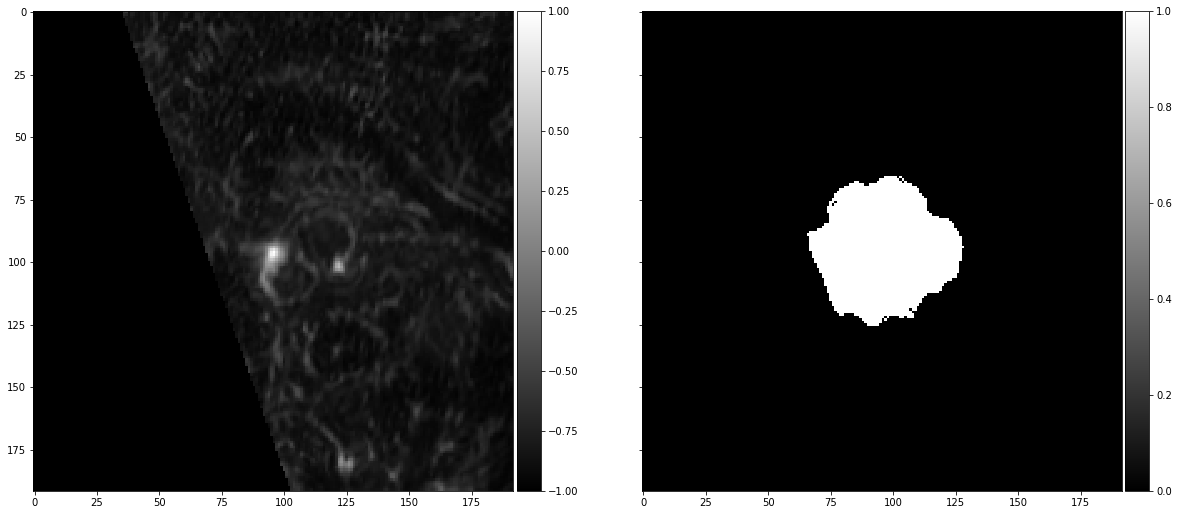

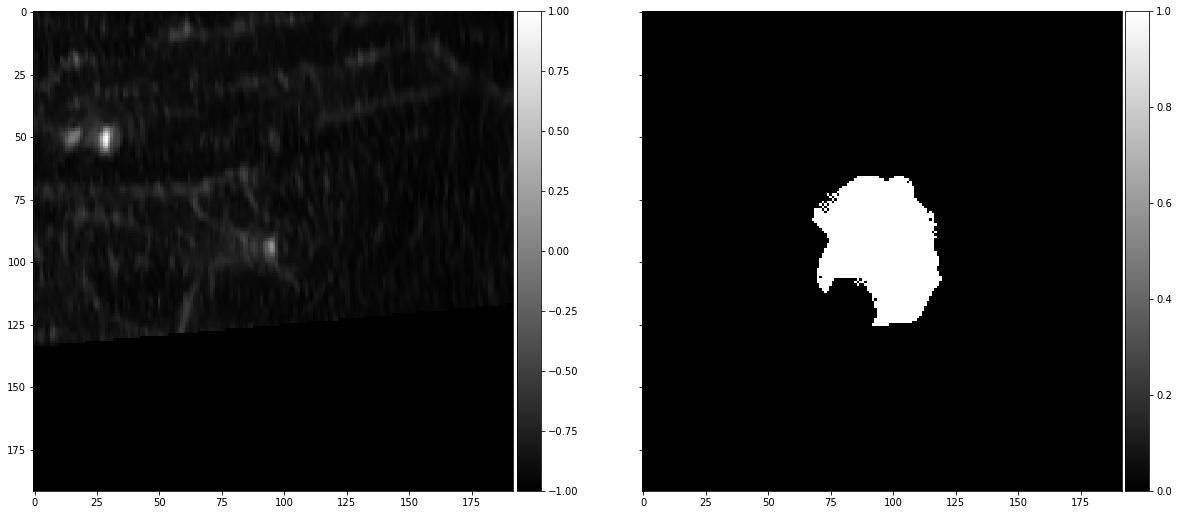

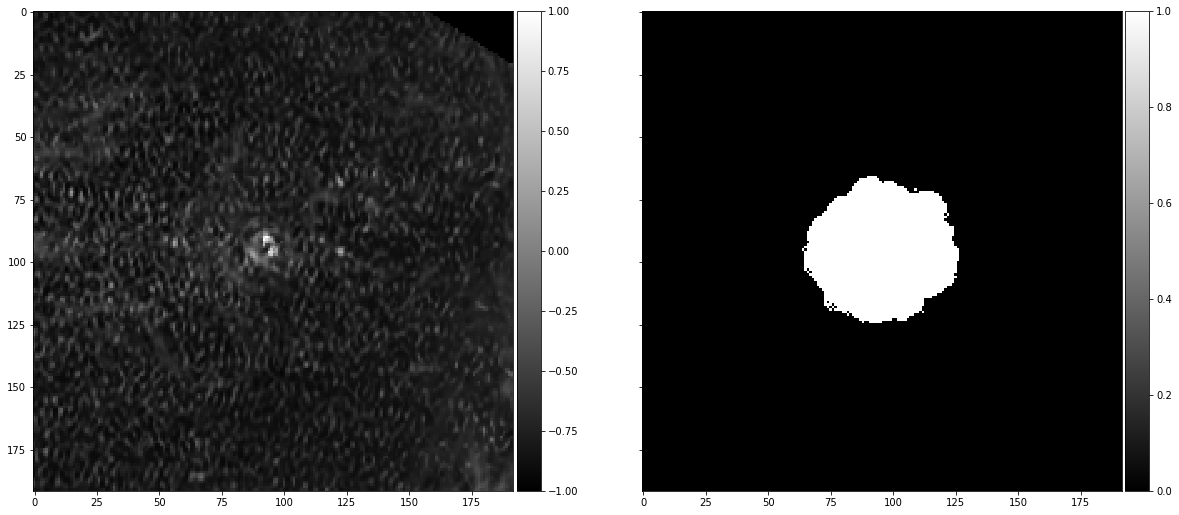

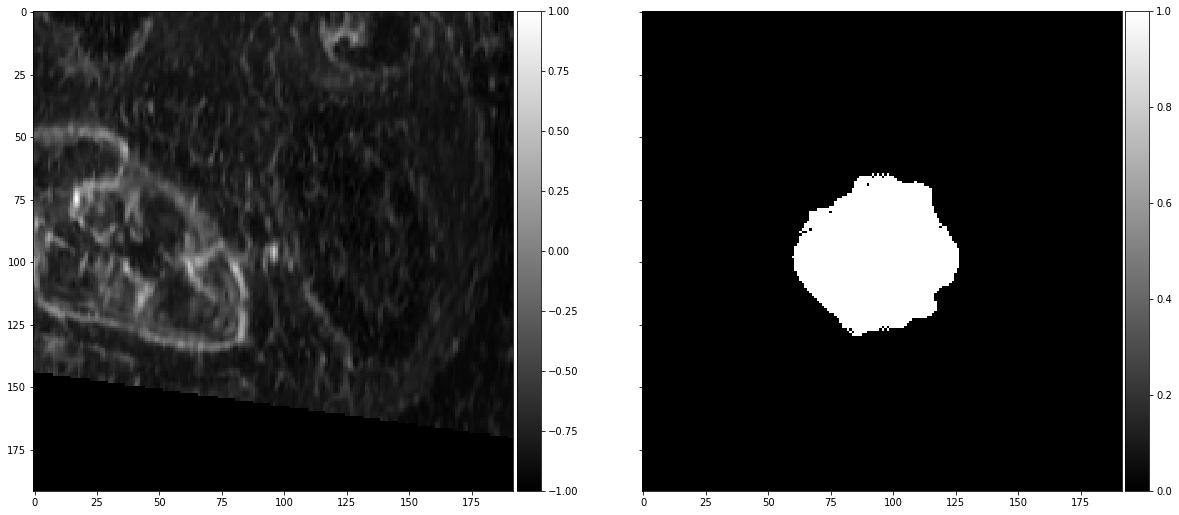

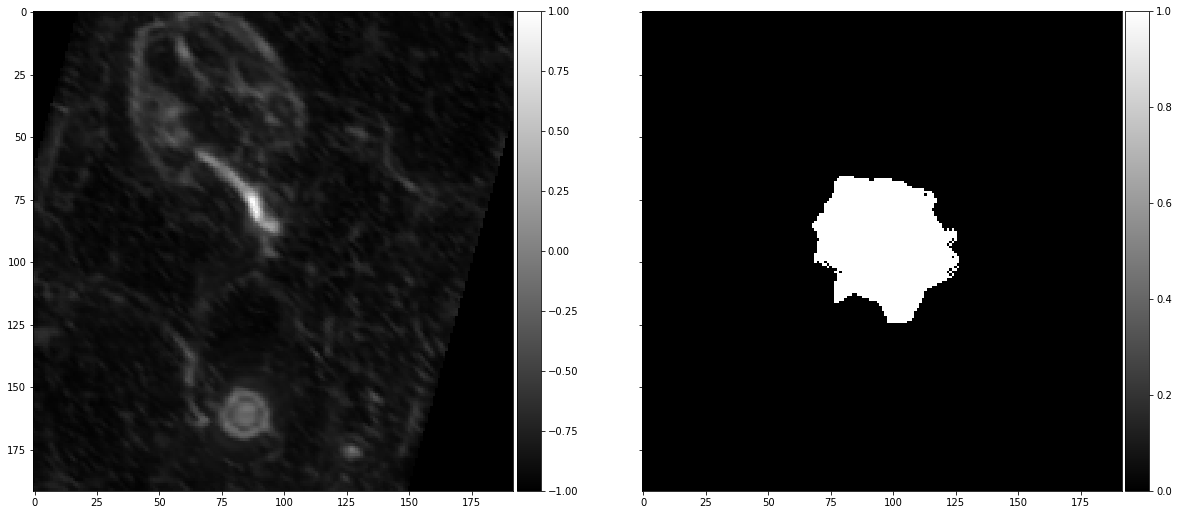

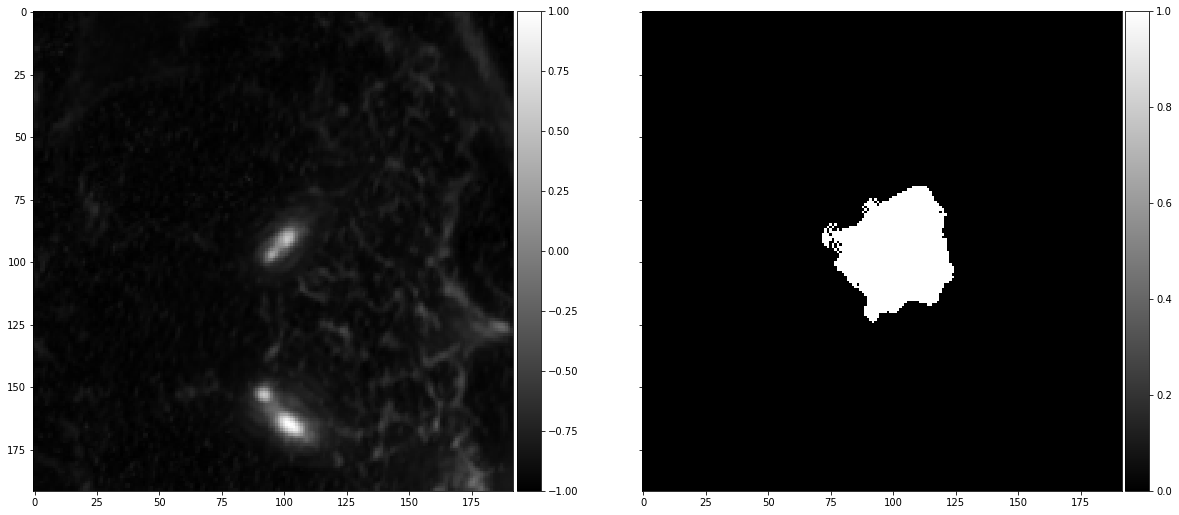

In [47]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(20):
    j = np.random.randint(N)
    im = X[j,:,:,0].astype(float)
    seg,cont = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(im,ax1)
    implot(seg,ax2)
    plt.tight_layout
    plt.show()

In [ ]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

mr_test = open('mr_test.txt').readlines()
mr_test = [i.replace('\n','') for i in mr_test]

test_images = []
test_images_mr = []
for i in range(len(mhas)):
    if any([c in mhas[i] for c in ct_test]):
        test_images.append((mhas[i],truths[i],paths[i],groups[i]))
    
    if any([c in mhas[i] for c in mr_test]):
        test_images_mr.append((mhas[i],truths[i],paths[i],groups[i]))
    
print test_images
print test_images_mr

In [ ]:
def batch_seg(X,crop_dims):
    N=X.shape[0]
    ypred=np.zeros((N,crop_dims,crop_dims,1)).astype(float)

    for i in range(0,N):
        img = utility.crop_center(X[i,:,:,0],crop_dims,crop_dims)
        seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
        
        ypred[i,:,:,0] = np.flipud(seg)
    return ypred.copy()

def ct_norm(x,im):
    return (1.0*x)/(3000)

def mr_norm(x,im):
    max_ = im.GetScalarRange()[1]
    min_ = im.GetScalarRange()[0]
    print min_,max_
    return (1.0*x-min_)/(max_-min_)

ext = [127, 127]
DIMS = [128,128]
ISOVALUE=0.5
NUM_MODES = 5

In [24]:
utility.gen_groups(test_images,batch_seg,ct_norm,
                ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'drls','./pred_groups')

/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha
(0.05859379842877388, 0.05859379842877388, 0.09000000357627869)
profunda_branch_left
profunda_left
knee_right
profunda_branch_right
anterior_tibial_right
knee_left
anterior_tibial_left
posterior_tibial_right
femoral_right
posterior_tibial_left
femoral_left
aorta_leg_right
celiac
leg_left
renal_right
superior_mesenteric_artery
internal_iliac_right
renal_left
profunda_right
internal_iliac_left
/home/marsdenlab/datasets/vascular_data/OSMSC0113/OSMSC0113-cm.mha
(0.0390625, 0.0390625, 0.0625)
N_RCA3
N_RCA
RCA
RCA2
N_RCA2
N_LCA4
N_LCA5
LCA
N_LCA
N_LCA2
N_LCA3
LCCA
LSA_b5
LSA_b3
LSA_b4
LSA_b1
LSA_b2
LSA
LIMA
RCCA
RSA
RSA_b1
RSA_b2
aorta
LCA2
/home/marsdenlab/datasets/vascular_data/OSMSC0118/OSMSC0118-cm.mha
(0.040820300579071045, 0.040820300579071045, 0.05000000074505806)
LPA_012
LPA_010
LPA_011
RPA_015
RPA_014
RPA_017
RPA_016
RPA_011
RPA_010
RPA_013
RPA_012
RPA_0082
RPA_0081
LPA_009
LPA_001
LPA
LPA_003
LPA_002
LPA_005
LPA_004

In [ ]:
utility.gen_groups(test_images_mr,batch_seg,mr_norm,
                ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'drls','./pred_groups')

In [ ]:
# /home/marsdenlab/datasets/vascular_data/OSMSC0189/OSMSC0189-cm.mha
# /home/marsdenlab/datasets/vascular_data/cabg10/cabg10-image.mha
# /home/marsdenlab/datasets/vascular_data/cabg11/cabg11-image.mha
# /home/marsdenlab/datasets/vascular_data/cabg5/cabg5-image.mha

# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0188-cm_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0189-cm_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg10-image_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg11-image_oof

oof_ct_tups = []
oof_mr_tups = []
def oof_norm(x):
    return x

for t in test_images:
    s = t[0]
    im_name = s.split('/')[-2]
    s = s.replace('/'+im_name+'/','/')
    s = s.replace('/home/marsdenlab/datasets/vascular_data','/media/marsdenlab/Data2/datasets/DeepLofting/OOF')
    s = s.replace('.mha','_oof.mha')
    print s
    
    oof_ct_tups.append((s,t[1],t[2],t[3]))
    
for t in test_images_mr:
    s = t[0]
    im_name = s.split('/')[-2]
    s = s.replace('/'+im_name+'/','/')
    s = s.replace('/home/marsdenlab/datasets/vascular_data','/media/marsdenlab/Data2/datasets/DeepLofting/OOF')
    s = s.replace('.mha','_oof.mha')
    print s
    
    oof_mr_tups.append((s,t[1],t[2],t[3]))
    
print oof_ct_tups

In [ ]:
# mu = 0.3
# lamda = 1.5
# alpha = 0.6
# R = 40

In [ ]:
# utility.gen_groups(oof_ct_tups,batch_seg,ct_norm,
#                 ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'oof','./pred_groups')

utility.gen_groups(oof_mr_tups,batch_seg,mr_norm,
                ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'oof','./pred_groups')